# ClimateNet AR/TC Analysis: Global Frequency Maps

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import xesmf as xe
import nc_time_axis
import cftime 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.colors as mcolors
import matplotlib as mpl

In [2]:
# Import dask
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
nmem1 = '7GiB' # PBSCluster specification
nmem2 = '7GB' # pbs specification
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory=nmem1, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='/glade/derecho/scratch/kdagon/dask-local', # Use your local directory
    resource_spec='select=1:ncpus=1:mem='+nmem2, # Specify resources
    account='P06010014', # Input your project ID here
    walltime='02:00:00', # Amount of wall time
    interface='ext', # Interface to use
)

# Scale up -- how to determine this number?
cluster.scale(15)

# Change your url to the dask dashboard so you can see it
#dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})
#dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/GPU/proxy/{port}/status'}) # need to include name of server if named!

# the above is for jupyterhub only, otherwise use /proxy/{port}/status (also need to launch ssh tunneling from the appropriate environment)
#dask.config.set({'distributed.dashboard.link': "/proxy/{port}/status"})
# really I should set these options in some sort of config file...

# Setup your client
client = Client(cluster)

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34965 instead
  warnings.warn(


In [3]:
client

<Client: 'tcp://128.117.208.101:37867' processes=0 threads=0, memory=0 B>

## Analysis notes
- replace `.where` with `.clip` if possible for speed

## Set ClimateNet filepath

In [4]:
#cesm_cnet_filepath = "/glade/campaign/cgd/amp/jet/ClimateNet/" # pretrained LBL model, 2000-2005
#cesm_cnet_filepath = "/glade/p/cgd/ccr/people/tking/cgnet_masks/" # retrained NCAR model, 2000-2015, after means/std bug fix

cesm_cnet_filepath = "/glade/campaign/cgd/ccr/kdagon/cgnet/" # retrained NCAR model, after data processing workflow was finalized

In [25]:
#cesm_cnet_folders = ["output.cgnet.2000/", "output.cgnet.2001/", "output.cgnet.2002/", "output.cgnet.2003/", "output.cgnet.2004/", "output.cgnet.2005/"] # pretrained LBL model, 2000-2005
#cesm_cnet_folders = ["results.2000/", "results.2001/", "results.2002/", "results.2003/", "results.2004/", "results.2005/"] # retrained NCAR model, 2000-2006, before means/std bug fix
#cesm_cnet_folders = ["results.2000/"] # year 2000 only
#cesm_cnet_folders = ["tmq_psl_v850_u850/"] # retrained NCAR model, 2000-2015, after means/std bug fix
#cesm_cnet_folders = ["tmq_v850/actual_tmq_v850_masks/"] # after config file bug fix
#cesm_cnet_folders = ["tmq_only/actual_tmq_only_masks/"] # after config file bug fix

## CESM historical & RCP2.6 simulations

### Check for missing values in new RCP2.6 masks

In [7]:
%%time
rcp26_folder = "BRCP26C5CN/2006/masks_v2/"
cnet_files = "class_masks*.nc"
cnet_test = xr.open_mfdataset(cesm_cnet_filepath+rcp26_folder+cnet_files, concat_dim='time',combine='nested', chunks={'time':50}, parallel=True)
cnet_test_mask = cnet_test.masks
cnet_test_mask_sum = cnet_test_mask.sum(dim=('lat','lon'))
cnet_test_mask_sum.where(cnet_test_mask_sum == 0).count().values

CPU times: user 2.04 s, sys: 288 ms, total: 2.33 s
Wall time: 14.5 s


array(0)

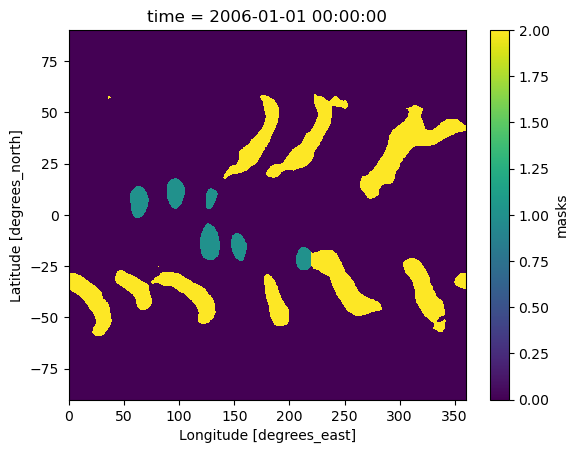

In [8]:
cnet_test_mask.isel(time=0).plot()

### Read in files

In [5]:
#cnet_files = "b.e13.B20TRC5CN.ne120_g16.003*.nc" # pretrained LBL model
#cnet_files = "class_masks*.nc" # retrained NCAR model
#cnet_files = "class_masks.200[0-5]*" # testing years 2000-2005

hist_yrs = [str(i) for i in range(2000,2006)]
#hist_folders = ["B20TRC5CN/"+y+"/masks/" for y in hist_yrs]
hist_folders = ["B20TRC5CN/"+y+"/masks_unwgt/" for y in hist_yrs] # unweighted means/std in config file
#hist_folders = ["B20TRC5CN/"+y+"/masks_histrcp26/" for y in hist_yrs] # unweighted means/std from CESM 2000-2015 in config file
#hist_folders = ["B20TRC5CN/"+y+"/masks_TMQ_V850/" for y in hist_yrs] # pre-trained model using TMQ and V850 only
#hist_folders = ["B20TRC5CN/"+y+"/masks_TMQ/" for y in hist_yrs] # pre-trained model using TMQ only

#rcp26_yrs = [str(i) for i in range(2006,2016)]
rcp26_yrs = [str(i) for i in range(2006,2015)] # 15-yr climatology
#rcp26_folders = ["BRCP26C5CN/"+y+"/masks/" for y in rcp26_yrs]
#rcp26_folders = ["BRCP26C5CN/"+y+"/masks_v2/" for y in rcp26_yrs] # updated data processing (3hrly PSL)
rcp26_folders = ["BRCP26C5CN/"+y+"/masks_unwgt/" for y in rcp26_yrs] # updated data processing (3hrly PSL), unweighted means/std in config file
#rcp26_folders = ["BRCP26C5CN/"+y+"/masks_histrcp26/" for y in rcp26_yrs] # unweighted means/std from CESM 2000-2015 in config file
#rcp26_folders = ["BRCP26C5CN/"+y+"/masks_TMQ_V850/" for y in rcp26_yrs] # pre-trained model using TMQ and V850 only
#rcp26_folders = ["BRCP26C5CN/"+y+"/masks_TMQ/" for y in rcp26_yrs] # pre-trained model using TMQ only

#cnet_folders = hist_folders+rcp26_folders
#cnet_folders

#cnet_files = "class_masks*.nc"

In [ ]:
# start with year 2000 only to solidfy workflow
#cnet_2000 = xr.open_mfdataset(cesm_cnet_filepath+cesm_cnet_folders[0]+cnet_files, concat_dim='time', combine="nested", chunks={'time':360}, parallel=True) # aim for chunk size < 100mb
#cnet_2000

#### Slower way to read in

In [7]:
%%time
# read in all the masks
# adjust chunks for length of timeseries data
#cnet = [xr.open_mfdataset(cesm_cnet_filepath+cesm_cnet_folders[i]+cnet_files, concat_dim='time',combine='nested', chunks={'time':50}, parallel=True) for i,f in enumerate(cesm_cnet_folders)]
cnet = [xr.open_mfdataset(cesm_cnet_filepath+cnet_folders[i]+cnet_files, concat_dim='time',combine='nested', chunks={'time':50}, parallel=True) for i,f in enumerate(cnet_folders)]

# concat across time
cnet_concat = xr.concat(cnet,dim='time')

CPU times: user 1.32 s, sys: 329 ms, total: 1.65 s
Wall time: 30.1 s


In [91]:
cnet_concat

<xarray.Dataset>
Dimensions:  (lon: 1152, lat: 768, time: 46720)
Coordinates:
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * time     (time) object 2000-01-01 03:00:00 ... 2015-12-31 21:00:00
Data variables:
    masks    (time, lat, lon) int64 dask.array<chunksize=(50, 768, 1152), meta=np.ndarray>

In [ ]:
#cnet_mask = cnet_concat.output_tag # pretrained LBL model
#cnet_mask = cnet_concat.__xarray_dataarray_variable__.rename("output_tag") # retrained NCAR model; rename data variable
cnet_mask = cnet_concat.masks
cnet_mask

#### Faster way to read in with one file per year

In [6]:
cnet_file = 'class_masks.nc' # can't use wildcard for this to work?
paths = [cesm_cnet_filepath+hist_folders[i]+cnet_file for i,f in enumerate(hist_folders)] + [cesm_cnet_filepath+rcp26_folders[i]+cnet_file for i,f in enumerate(rcp26_folders)]
paths

['/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2000/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2001/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2002/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2003/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2004/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2005/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2006/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2007/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2008/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2009/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2010/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2011/masks_unwgt/class_masks.nc'

In [7]:
%%time
# read in all the masks feeding the list of paths - faster!
cnet = xr.open_mfdataset(paths, concat_dim='time', combine='nested', chunks={'time':50}, parallel=True)
cnet

CPU times: user 2 s, sys: 515 ms, total: 2.51 s
Wall time: 14.7 s


<xarray.Dataset>
Dimensions:  (lon: 1152, lat: 768, time: 43800)
Coordinates:
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * time     (time) object 2000-01-01 03:00:00 ... 2014-12-31 21:00:00
Data variables:
    masks    (time, lat, lon) int64 dask.array<chunksize=(50, 768, 1152), meta=np.ndarray>

In [8]:
cnet_mask = cnet.masks
cnet_mask

<xarray.DataArray 'masks' (time: 43800, lat: 768, lon: 1152)>
dask.array<concatenate, shape=(43800, 768, 1152), dtype=int64, chunksize=(50, 768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * time     (time) object 2000-01-01 03:00:00 ... 2014-12-31 21:00:00
Attributes: (12/21)
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    history:                    Fri Feb 17 16:11:24 2023: cdo splitsel,1 2000...
    remap_script:               ncremap
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    ...                         ...
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /projects/ccsm/inputdata/atm/cam/inic/homme/c...
    topography_file:            /projects/ccsm/inputdata/atm/cam/topo/USGS-gt...
    history_of_appended_files:  Fri Feb 17 15:31:33 2023: Appended file 2000_...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...

#### Note the repeating index where the files meet
Can correct this with timeshift but should not matter for these frequency plots

In [9]:
cnet_mask.sel(time="2006-01-01 00:00:00")

<xarray.DataArray 'masks' (time: 2, lat: 768, lon: 1152)>
dask.array<getitem, shape=(2, 768, 1152), dtype=int64, chunksize=(1, 768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * time     (time) object 2006-01-01 00:00:00 2006-01-01 00:00:00
Attributes: (12/21)
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    history:                    Fri Feb 17 16:11:24 2023: cdo splitsel,1 2000...
    remap_script:               ncremap
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    ...                         ...
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /projects/ccsm/inputdata/atm/cam/inic/homme/c...
    topography_file:            /projects/ccsm/inputdata/atm/cam/topo/USGS-gt...
    history_of_appended_files:  Fri Feb 17 15:31:33 2023: Appended file 2000_...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...

### Static plot for visualization

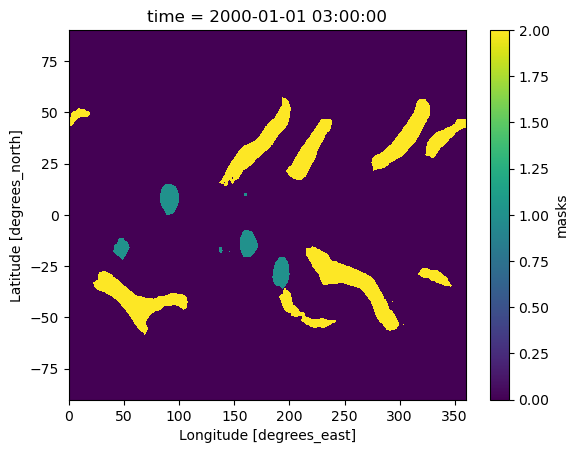

In [45]:
cnet_mask.isel(time=0).plot();

### Check for time indices with zero detection

In [10]:
cnet_mask_sum = cnet_mask.sum(dim=('lat','lon'))

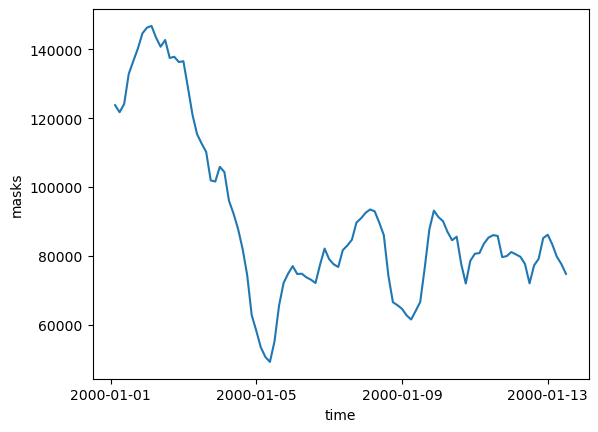

In [11]:
cnet_mask_sum.isel(time=slice(0,100)).plot();

In [12]:
cnet_mask_sum.where(cnet_mask_sum == 0).count().values

array(0)

Historical/RCP2.6 doesn't have any "empty" time indices

### A nicer static plot

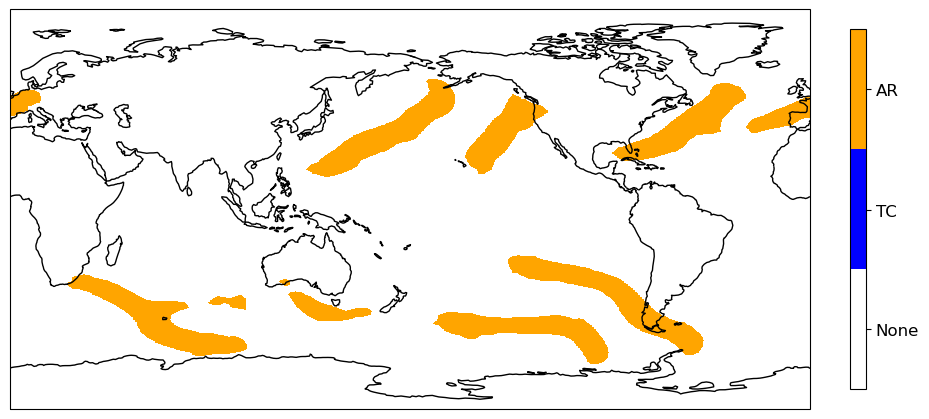

In [14]:
cmap_all = mcolors.ListedColormap(['w', 'blue', 'orange'])
bounds = [0, 0.99, 1.99, 2.99]
#norm = mcolors.BoundaryNorm(bounds, cmap_all.N)

fig = plt.figure(figsize=(8,6))

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree(central_longitude=180.0)) # shift map center to highlight Pacific

lat = cnet_mask.lat
lon = cnet_mask.lon
#cf = ax.contourf(lon, lat, cnet_mask.isel(time=0), cmap=cmap_all, vmin=0, vmax=2.99, levels=bounds, transform=ccrs.PlateCarree())
pc = ax.pcolormesh(lon, lat, cnet_mask.isel(time=0), cmap=cmap_all, vmin=0, vmax=2.99, transform=ccrs.PlateCarree()) # get rid of edge colors

ax.coastlines()

cbar_ax = fig.add_axes([1.05, 0.2, 0.02, 0.6])
norm = mpl.colors.Normalize(vmin=0, vmax=2.99)
cb1 = mpl.colorbar.ColorbarBase(cbar_ax, 
                                cmap=cmap_all,
                                norm=norm,
                                orientation='vertical', 
                               ticks=bounds)
labels = np.array([0, 0.99, 1.99])
loc    = labels + .5
tick_1 = ['None','TC','AR']
cb1.set_ticks(loc)
cb1.ax.set_yticklabels(tick_1)
cb1.ax.tick_params(labelsize=12)

#plt.savefig('../figures/toSCP/CGnet_time=0_beforebugfix.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/CGnet_time=0_afterbugfix.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/CGnet_time=0_tmq-v850.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/CGnet_time=0_tmq-only.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/CGnet_time=0_tmq-v850_configfix.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/CGnet_time=0_tmq-only_configfix.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/CGnet_time=0.png', bbox_inches='tight')

### Global AR frequency maps
See Lora et al. 2020 for comparison

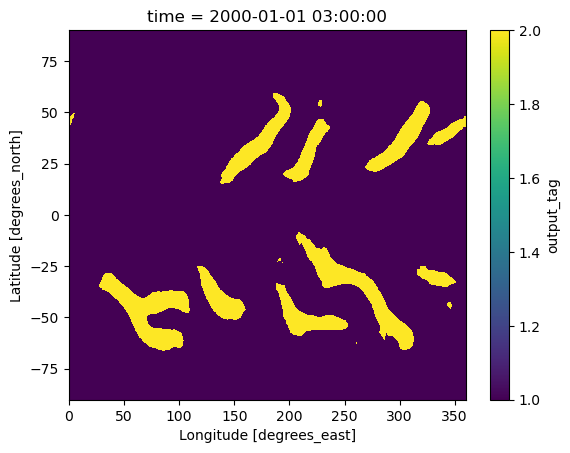

In [32]:
# TCs are still here, but now everything not AR has been set to 1
cnet_mask.clip(min=1).isel(time=0).plot();

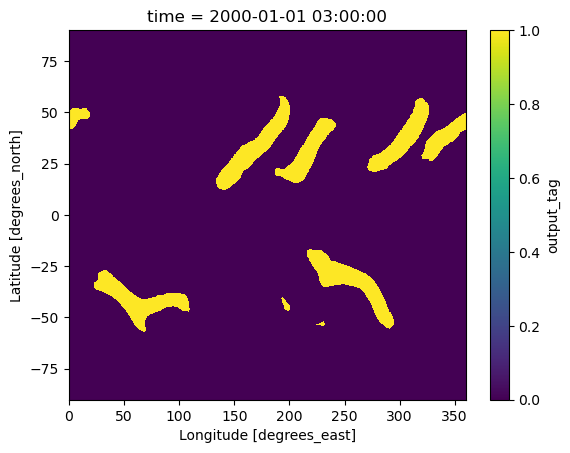

In [20]:
# method to select only ARs (value=2)
# clip is so much faster than where but it doesn't create a masked array
(cnet_mask.clip(min=1).isel(time=0)-1).plot(); # in absense of masked array, need to subtract 1 to get ARs = 1 and everything else = 0

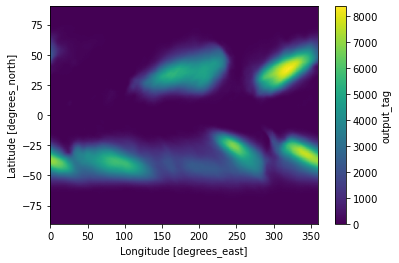

In [28]:
# sum at each gridpoint over time
(cnet_mask.clip(min=1)-1).sum(dim='time').plot()

In [29]:
len(cnet_mask.time)

17520

In [9]:
len(cnet_mask.time)

43800

In [9]:
npercentARs = 100*((cnet_mask.clip(min=1)-1).sum(dim='time'))/len(cnet_mask.time)
#npercentARs.plot(robust=True);

In [10]:
npercentARs = npercentARs.persist()

In [21]:
npercentARs.max().values

array(44.69863014)

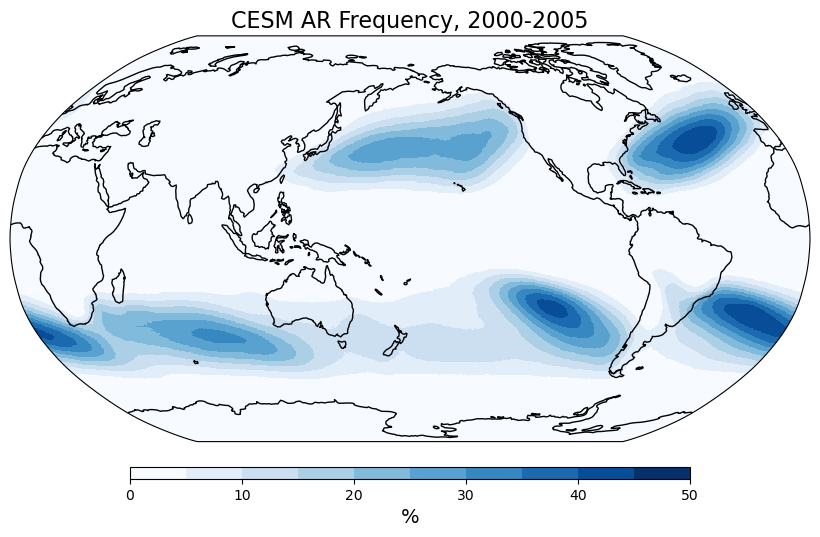

In [25]:
# a nicer plot
fig = plt.figure(figsize=(8,6))

cmap=plt.cm.get_cmap('Blues', 10)
vmax=50

# compare to Lora et al. 2020
#cmap=plt.cm.get_cmap('Blues', 10)
#vmax=25 # compare to Lora et al. 2020

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.Robinson(central_longitude=180.0))

lat = npercentARs.lat
lon = npercentARs.lon
pc = ax.pcolormesh(lon, lat, npercentARs, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())

ax.coastlines()

# add colorbar
cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.02])
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal')
#cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal', extend='max')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
ax.set_title('CESM AR Frequency, 2000-2005', fontsize=16); 
#ax.set_title('CESM AR Frequency, 2000-2015\nNormalization values from CESM climatology', fontsize=16); 

#plt.savefig('../figures/toSCP/npercentARs_CESM_hist_beforebugfix.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentARs_CESM_hist_afterbugfix.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentARs_CESM_hist_rcp26_tmq-v850.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentARs_CESM_hist_rcp26_tmq-only.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentARs_CESM_hist_rcp26_tmq-v850_configfix.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentARs_CESM_hist_rcp26_tmq-only_configfix.png', bbox_inches='tight')

#plt.savefig('../figures/toSCP/npercentARs_CESM_hist_rcp26.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentARs_CESM_hist_rcp26_unwgt.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentARs_CESM_hist_rcp26_unwgt_Lora.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentARs_CESM_hist_rcp26_unwgt_config.png', bbox_inches='tight')

In [12]:
# save the AR freq from the updated normalization values; then go read in the next set for comparison
#npercentARs_histrcp = npercentARs
npercentARs_wgt = npercentARs

#### Compare impact of different normalization values

In [20]:
# CESM1.3 hist/rcp26 2000-2015 minus CAM5 1996-2010 (not every timestep)
#npercentARs_normdiff = npercentARs_histrcp - npercentARs

# Weighted vs unweighted means
npercentARs_wgtdiff = npercentARs_wgt - npercentARs

In [25]:
print(npercentARs_normdiff.min().values, npercentARs_normdiff.max().values)

-1.6575342465753415 2.9200913242009143


In [21]:
print(npercentARs_wgtdiff.min().values, npercentARs_wgtdiff.max().values)

-1.6894977168949765 27.787671232876715


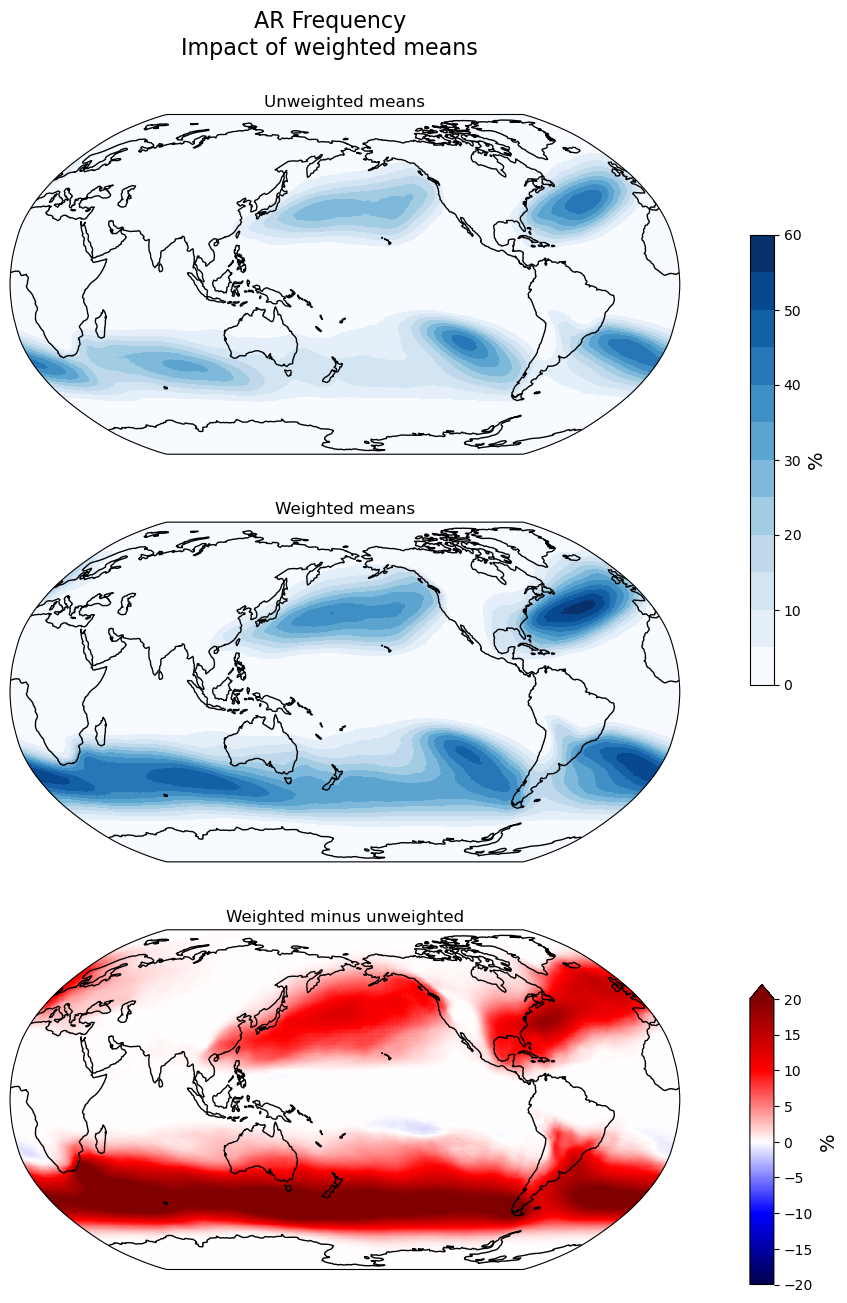

In [45]:
fig, axes = plt.subplots(3, 1, figsize=(12, 15), subplot_kw={'projection': ccrs.Robinson(central_longitude=180.0)})  # 3 rows, 1 column

#cmap=plt.cm.get_cmap('Blues', 10)
#vmax=50 

cmap=plt.cm.get_cmap('Blues', 12)
vmax=60

lat = npercentARs.lat
lon = npercentARs.lon

# CAM5 training data / Unweighted means
pc = axes[0].pcolormesh(lon, lat, npercentARs, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
axes[0].coastlines()
#axes[0].set_title('CAM5 training data (1996-2010 not every timestep)')
axes[0].set_title('Unweighted means')

# CESM1.3 hist/rcp climatology
#pc = axes[1].pcolormesh(lon, lat, npercentARs_histrcp, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
# Weighted means
pc = axes[1].pcolormesh(lon, lat, npercentARs_wgt, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
axes[1].coastlines()
#axes[1].set_title('CESM1.3 historical/RCP2.6 climatology (2000-2015)')
axes[1].set_title('Weighted means')

# add colorbar
cbar_ax = fig.add_axes([0.85, 0.5, 0.02, 0.3]) #(left, bottom, width, height)
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='vertical')
cbar.ax.set_ylabel('%', fontsize=14)

# diff
cmap=plt.cm.get_cmap('seismic')
#vmin=-3
#vmax=3

vmin=-20
vmax=20

#pc = axes[2].pcolormesh(lon, lat, npercentARs_normdiff, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
pc = axes[2].pcolormesh(lon, lat, npercentARs_wgtdiff, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
axes[2].coastlines()
#axes[2].set_title('CESM minus CAM')
axes[2].set_title('Weighted minus unweighted')

cbar_ax = fig.add_axes([0.85, 0.1, 0.02, 0.2]) #(left, bottom, width, height)
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='vertical', extend='max')
cbar.ax.set_ylabel('%', fontsize=14)

# add suptitle
#fig.suptitle('AR Frequency\nImpact of normalization values', fontsize=16, y=0.95)
fig.suptitle('AR Frequency\nImpact of weighted means', fontsize=16, y=0.95)

#plt.savefig('../figures/toSCP/npercentARs_CESM_normdiff.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentARs_CESM_wgtdiff.png', bbox_inches='tight')

### Global TC frequency masks
Note: release the ``npercentARs`` variable from memory so the ``npercentTCs`` processing doesn't run out of memory (or increase the dask request?)

In [37]:
del npercentARs

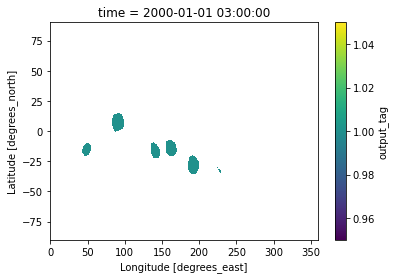

In [29]:
# can't figure out how to use .clip to select TCs
(cnet_mask.where(cnet_mask==1).isel(time=0)).plot() 

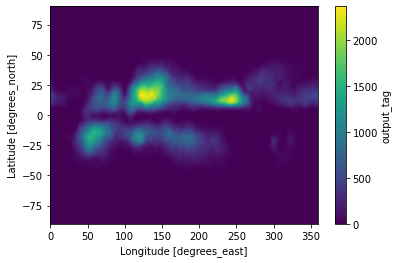

In [32]:
cnet_mask.where(cnet_mask==1).sum(dim='time').plot()

In [33]:
len(cnet_mask.time)

17520

In [9]:
# can't figure out how to use .clip to select TCs
npercentTCs = 100*(cnet_mask.where(cnet_mask==1).sum(dim='time'))/len(cnet_mask.time)

In [78]:
npercentTCs

<xarray.DataArray 'output_tag' (lat: 768, lon: 1152)>
dask.array<truediv, shape=(768, 1152), dtype=float64, chunksize=(768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7

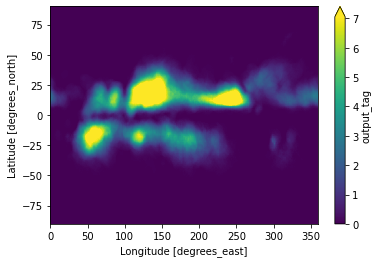

In [ ]:
npercentTCs.plot(robust=True);

In [10]:
npercentTCs = npercentTCs.persist()

In [11]:
npercentTCs.max().values

array(0.01284247)

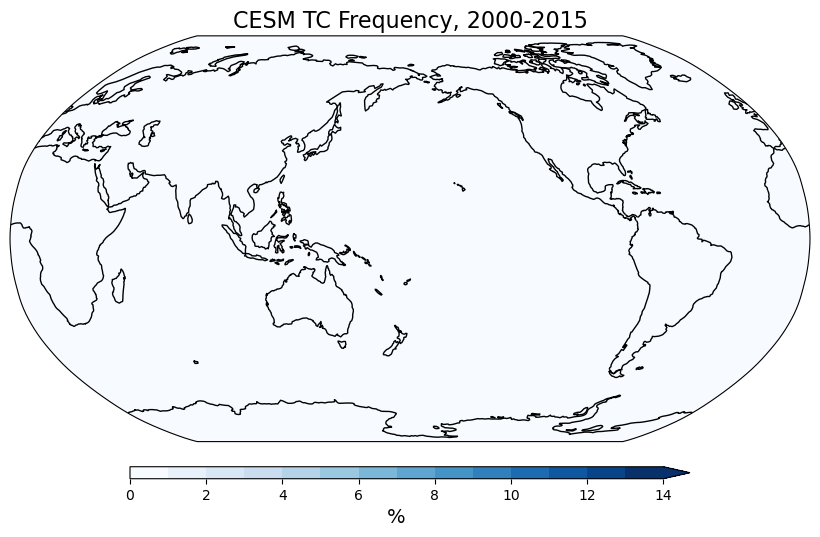

In [12]:
# a nicer plot
fig = plt.figure(figsize=(8,6))

cmap=plt.cm.get_cmap('Blues', 14)
vmax=14

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.Robinson(central_longitude=180.0))

lat = npercentTCs.lat
lon = npercentTCs.lon
pc = ax.pcolormesh(lon, lat, npercentTCs, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())

ax.coastlines()

# add colorbar
cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.02])
#cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal')
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal', extend='max')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
#ax.set_title('CESM TC Frequency, 2000-2005', fontsize=16); 
ax.set_title('CESM TC Frequency, 2000-2015', fontsize=16);

#plt.savefig('../figures/toSCP/npercentTCs_CESM_hist_beforebugfix.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentTCs_CESM_hist_afterbugfix.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentTCs_CESM_hist_rcp26_tmq-v850.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentTCs_CESM_hist_rcp26_tmq-only.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentTCs_CESM_hist_rcp26_tmq-v850_configfix.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentTCs_CESM_hist_rcp26_tmq-only_configfix.png', bbox_inches='tight')

#plt.savefig('../figures/toSCP/npercentTCs_CESM_hist_rcp26.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentTCs_CESM_hist_rcp26_unwgt.png', bbox_inches='tight')

## CESM RCP8.5 simulations

### Check for missing values in new RCP8.5 masks

In [7]:
%%time
rcp85_folder = "BRCP85C5CN/2086/masks_v2/"
cnet_files = "class_masks*.nc"
cnet_test = xr.open_mfdataset(cesm_cnet_filepath+rcp85_folder+cnet_files, concat_dim='time',combine='nested', chunks={'time':50}, parallel=True)
cnet_test_mask = cnet_test.masks
cnet_test_mask_sum = cnet_test_mask.sum(dim=('lat','lon'))
cnet_test_mask_sum.where(cnet_test_mask_sum == 0).count().values

CPU times: user 507 ms, sys: 44.9 ms, total: 552 ms
Wall time: 10.7 s


array(0)

In [9]:
cnet_test_mask

<xarray.DataArray 'masks' (time: 2920, lat: 768, lon: 1152)>
dask.array<open_dataset-64bf225eb5f2cd292c7f7de8dfe35768masks, shape=(2920, 768, 1152), dtype=int64, chunksize=(50, 768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * time     (time) object 2086-01-01 00:00:00 ... 2086-12-31 21:00:00
Attributes: (12/23)
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    remap_script:               ncremap
    remap_version:              4.7.9
    map_file:                   /glade/campaign/cgd/amp/jet/ClimateNet/data_p...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...
    ...                         ...
    host:                       nid02781
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /global/project/projectdirs/ccsm1/inputdata/a...
    topography_file:            /global/project/projectdirs/ccsm1/inputdata/a...
    history_of_appended_files:  Mon Apr  3 13:13:47 2023: Appended file outpu...

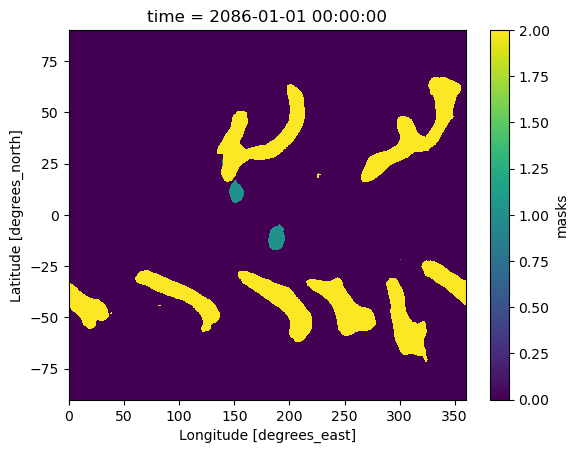

In [8]:
cnet_test_mask.isel(time=0).plot()

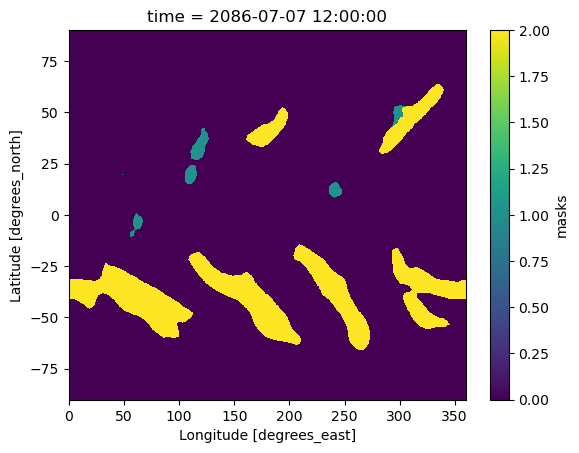

In [11]:
cnet_test_mask.isel(time=1500).plot();

### Read in files

In [11]:
rcp85_yrs = [str(i) for i in range(2086,2101)]
#rcp85_folders = ["BRCP85C5CN/"+y+"/masks/" for y in rcp85_yrs]
#rcp85_folders = ["BRCP85C5CN/"+y+"/masks_v2/" for y in rcp85_yrs] # updated data processing (raw U850/V850)
#rcp85_folders = ["BRCP85C5CN/"+y+"/masks_unwgt/" for y in rcp85_yrs] # unweighted means/std in config file
rcp85_folders = ["BRCP85C5CN/"+y+"/masks_rcp85config/" for y in rcp85_yrs] # RCP8.5 data used to calculate means/std in config file (unweighted)

#cnet_files = "class_masks*.nc"

#### Slower way to read in

In [7]:
%%time
# read in all the masks
# adjust chunks for length of timeseries data
cnet = [xr.open_mfdataset(cesm_cnet_filepath+rcp85_folders[i]+cnet_files, concat_dim='time',combine='nested', chunks={'time':100}, parallel=True) for i,f in enumerate(cnet_folders)]

# concat across time
cnet_concat = xr.concat(cnet,dim='time')

CPU times: user 2.12 s, sys: 405 ms, total: 2.52 s
Wall time: 21.5 s


In [8]:
cnet_concat

<xarray.Dataset>
Dimensions:  (lon: 1152, lat: 768, time: 43800)
Coordinates:
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * time     (time) object 2086-01-01 00:00:00 ... 2100-12-31 21:00:00
Data variables:
    masks    (time, lat, lon) int64 dask.array<chunksize=(100, 768, 1152), meta=np.ndarray>

In [9]:
cnet_mask = cnet_concat.masks
cnet_mask

<xarray.DataArray 'masks' (time: 43800, lat: 768, lon: 1152)>
dask.array<concatenate, shape=(43800, 768, 1152), dtype=int64, chunksize=(100, 768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * time     (time) object 2086-01-01 00:00:00 ... 2100-12-31 21:00:00
Attributes: (12/23)
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    history:                    Mon Feb 20 14:02:32 2023: cdo splitsel,1 2086...
    remap_script:               ncremap
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    ...                         ...
    host:                       nid02781
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /global/project/projectdirs/ccsm1/inputdata/a...
    topography_file:            /global/project/projectdirs/ccsm1/inputdata/a...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...

#### Faster way to read in

In [12]:
cnet_file_rcp85 = 'class_masks.nc' # can't use wildcard for this to work?
rcp85_paths = [cesm_cnet_filepath+rcp85_folders[i]+cnet_file_rcp85 for i,f in enumerate(rcp85_folders)]
rcp85_paths

['/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2086/masks_rcp85config/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2087/masks_rcp85config/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2088/masks_rcp85config/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2089/masks_rcp85config/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2090/masks_rcp85config/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2091/masks_rcp85config/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2092/masks_rcp85config/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2093/masks_rcp85config/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2094/masks_rcp85config/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2095/masks_rcp85config/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2096/masks_rcp85config/class_masks.nc',
 '/glade/c

In [13]:
%%time
# read in all the masks feeding the list of paths - faster!
cnet_rcp85 = xr.open_mfdataset(rcp85_paths, concat_dim='time', combine='nested', chunks={'time':50}, parallel=True)
cnet_rcp85

CPU times: user 383 ms, sys: 33.4 ms, total: 417 ms
Wall time: 602 ms


<xarray.Dataset>
Dimensions:  (lat: 768, lon: 1152, time: 43800)
Coordinates:
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * time     (time) object 2086-01-01 00:00:00 ... 2100-12-31 21:00:00
Data variables:
    masks    (time, lat, lon) int64 dask.array<chunksize=(50, 768, 1152), meta=np.ndarray>

In [14]:
cnet_mask_rcp85 = cnet_rcp85.masks

### Static plot for visualization

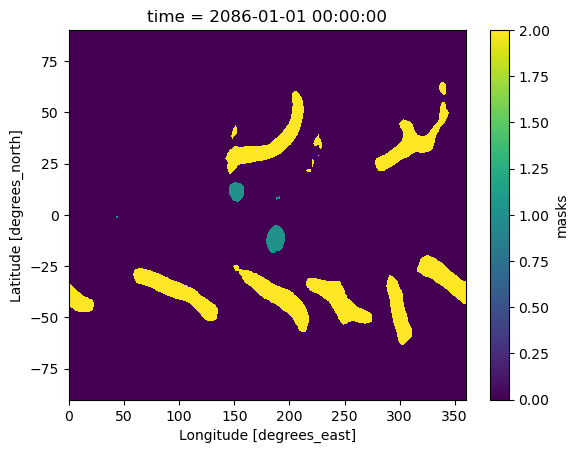

In [58]:
cnet_mask_rcp85.isel(time=0).plot();

### Check for time indices with zero detection

In [59]:
cnet_mask_rcp85_sum = cnet_mask_rcp85.sum(dim=('lat','lon'))

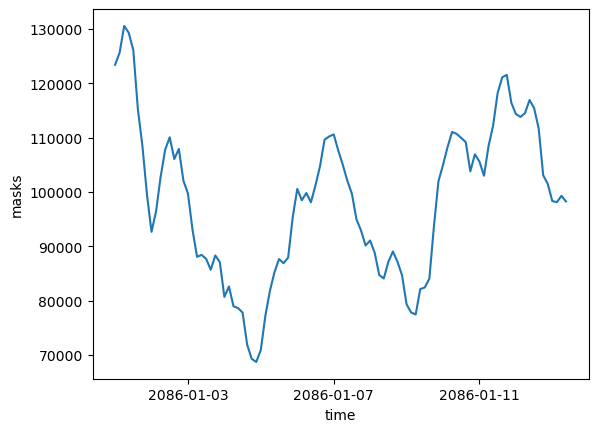

In [60]:
cnet_mask_rcp85_sum.isel(time=slice(0,100)).plot()

In [32]:
cnet_mask_rcp85_sum.where(cnet_mask_rcp85_sum == 0).count().values

array(0)

RCP8.5 doesn't have any "empty" time indices

### Debugging zero detection time points
How many zero detection time points are there?

In [13]:
%%time
cnet_mask_sum.where(cnet_mask_sum == 0).count().values

array(1098)

This is ~2.5% of all time points for RCP8.5

In [14]:
1098/43800

0.02506849315068493

#### What are the indices?

In [15]:
cnet_mask_sum.where(cnet_mask_sum == 0).isel(time=slice(0,100)).values

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan,  0., nan, nan,  0., nan, nan, nan, nan, nan, nan, nan,
       nan, nan,  0., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan,  0., nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan])

#### Print/visualize the zero time indices
They seem to be random but good to check

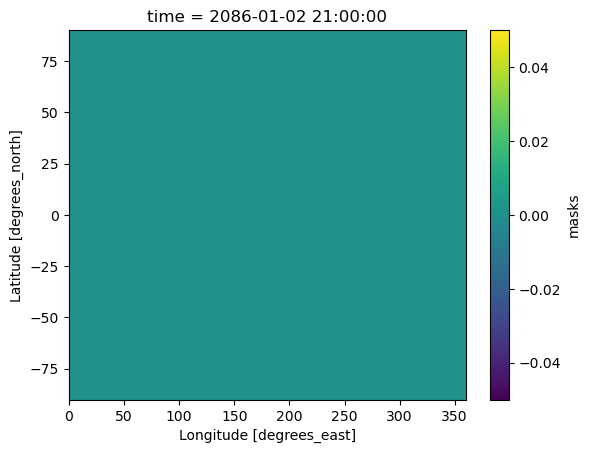

In [16]:
cnet_mask.isel(time=15).plot();

In [17]:
cnet_mask.isel(time=15, lat=10, lon=10).values

array(0)

In [18]:
cnet_mask_sum.where(cnet_mask_sum == 0)

<xarray.DataArray 'masks' (time: 43800)>
dask.array<where, shape=(43800,), dtype=float64, chunksize=(100,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2086-01-01 00:00:00 ... 2100-12-31 21:00:00

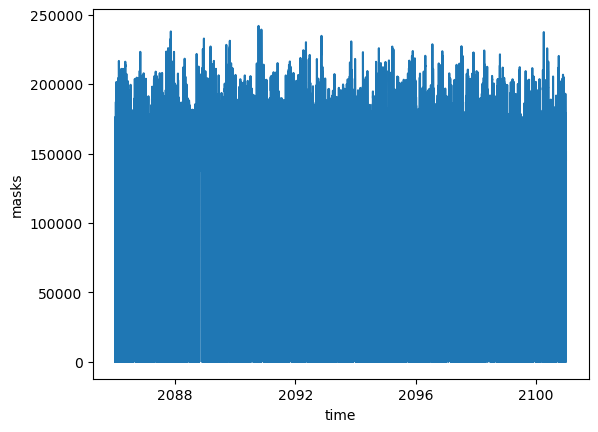

In [57]:
cnet_mask_sum.plot()

In [20]:
%%time
cnet_mask_sum.where(cnet_mask_sum == 0, drop=True)

CPU times: user 23.3 s, sys: 780 ms, total: 24 s
Wall time: 1min 56s


<xarray.DataArray 'masks' (time: 1098)>
dask.array<where, shape=(1098,), dtype=float64, chunksize=(8,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2086-01-02 21:00:00 ... 2100-12-31 15:00:00

In [22]:
%%time
print(cnet_mask_sum.where(cnet_mask_sum == 0, drop=True).time.values)

[cftime.DatetimeNoLeap(2086, 1, 2, 21, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2086, 1, 3, 6, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2086, 1, 4, 12, 0, 0, 0, has_year_zero=True) ...
 cftime.DatetimeNoLeap(2100, 12, 22, 18, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2100, 12, 23, 3, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2100, 12, 31, 15, 0, 0, 0, has_year_zero=True)]
CPU times: user 26.3 s, sys: 920 ms, total: 27.3 s
Wall time: 2min 5s


CPU times: user 21.8 s, sys: 755 ms, total: 22.5 s
Wall time: 1min 40s


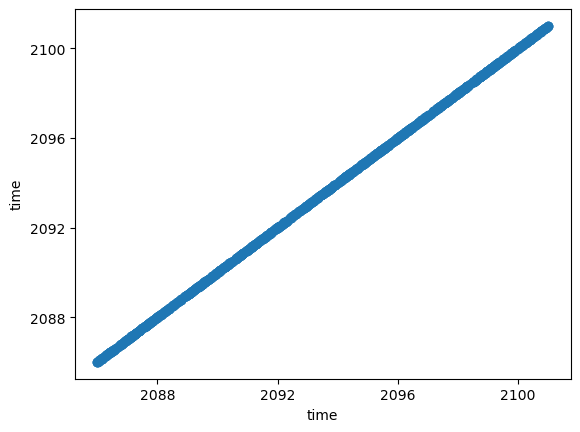

In [24]:
%%time
cnet_mask_sum.where(cnet_mask_sum == 0, drop=True).time.plot(marker="o")

### Trying again with pre-trained model using means/std updated for RCP8.5 data
Only ran for 2086-2089 to test

In [22]:
rcp85test_yrs = [str(i) for i in range(2086,2090)]
cnet_test_folders = ["BRCP85C5CN/"+y+"/masks_rcp85config/" for y in rcp85test_yrs]

cnet_files = "class_masks*.nc"

In [23]:
cnet_test_folders

['BRCP85C5CN/2086/masks_rcp85config/',
 'BRCP85C5CN/2087/masks_rcp85config/',
 'BRCP85C5CN/2088/masks_rcp85config/',
 'BRCP85C5CN/2089/masks_rcp85config/']

In [24]:
%%time
cnet_test = [xr.open_mfdataset(cesm_cnet_filepath+cnet_test_folders[i]+cnet_files, concat_dim='time',combine='nested', chunks={'time':50}, parallel=True) for i,f in enumerate(cnet_test_folders)]

# concat across time
cnet_test_concat = xr.concat(cnet_test,dim='time')

CPU times: user 133 ms, sys: 4.24 ms, total: 137 ms
Wall time: 445 ms


In [25]:
cnet_test_concat

<xarray.Dataset>
Dimensions:  (lon: 1152, lat: 768, time: 11680)
Coordinates:
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * time     (time) object 2086-01-01 00:00:00 ... 2089-12-31 21:00:00
Data variables:
    masks    (time, lat, lon) int64 dask.array<chunksize=(50, 768, 1152), meta=np.ndarray>

In [26]:
cnet_test_mask = cnet_test_concat.masks
cnet_test_mask

<xarray.DataArray 'masks' (time: 11680, lat: 768, lon: 1152)>
dask.array<concatenate, shape=(11680, 768, 1152), dtype=int64, chunksize=(50, 768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * time     (time) object 2086-01-01 00:00:00 ... 2089-12-31 21:00:00
Attributes: (12/23)
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    history:                    Mon Feb 20 14:02:32 2023: cdo splitsel,1 2086...
    remap_script:               ncremap
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    ...                         ...
    host:                       nid02781
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /global/project/projectdirs/ccsm1/inputdata/a...
    topography_file:            /global/project/projectdirs/ccsm1/inputdata/a...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...

In [27]:
cnet_test_mask_sum = cnet_test_mask.sum(dim=('lat','lon'))

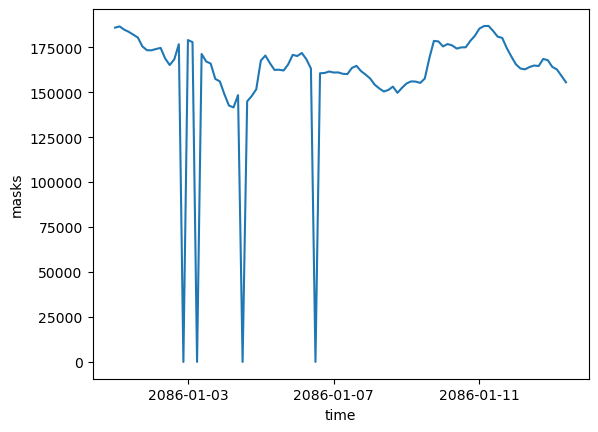

In [28]:
cnet_test_mask_sum.isel(time=slice(0,100)).plot()

In [30]:
cnet_test_mask_sum.where(cnet_test_mask_sum == 0).isel(time=slice(0,100)).values

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan,  0., nan, nan,  0., nan, nan, nan, nan, nan, nan, nan,
       nan, nan,  0., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan,  0., nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan])

#### The indices are the same, despite changing the normalization values
Detection does look to vary slightly with different values, but the zero detection points are consistent

### Debugging the first problematic index - CESM variables

In [6]:
datacheck = xr.open_dataset(cesm_cnet_filepath+'BRCP85C5CN/2086/2086_all_vars_split000016.nc')
datacheck

<xarray.Dataset>
Dimensions:    (time: 1, bnds: 2, slat: 767, lat: 768, lon: 1152)
Coordinates:
  * time       (time) object 2086-01-02 21:00:00
  * slat       (slat) float64 -89.88 -89.65 -89.41 -89.18 ... 89.41 89.65 89.88
  * lat        (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon        (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
Dimensions without coordinates: bnds
Data variables: (12/20)
    time_bnds  (time, bnds) object ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    w_stag     (slat) float64 ...
    gw         (lat) float64 ...
    V850       (time, lat, lon) float32 ...
    ...         ...
    f12vmr     (time) float64 ...
    n2ovmr     (time) float64 ...
    ndcur      (time) int32 ...
    nscur      (time) int32 ...
    nsteph     (time) int32 ...
    sol_tsi    (time) float64 ...
Attributes: (12/23)
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    history:                    Mon Feb 20 14:02:32 2023: cdo splitsel,1 2086...
    remap_script:               ncremap
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    ...                         ...
    host:                       nid02781
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /global/project/projectdirs/ccsm1/inputdata/a...
    topography_file:            /global/project/projectdirs/ccsm1/inputdata/a...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...

In [36]:
datacheck.PSL

<xarray.DataArray 'PSL' (time: 1, lat: 768, lon: 1152)>
[884736 values with dtype=float32]
Coordinates:
  * time     (time) object 2086-01-02 21:00:00
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
Attributes:
    long_name:  Sea level pressure
    units:      Pa

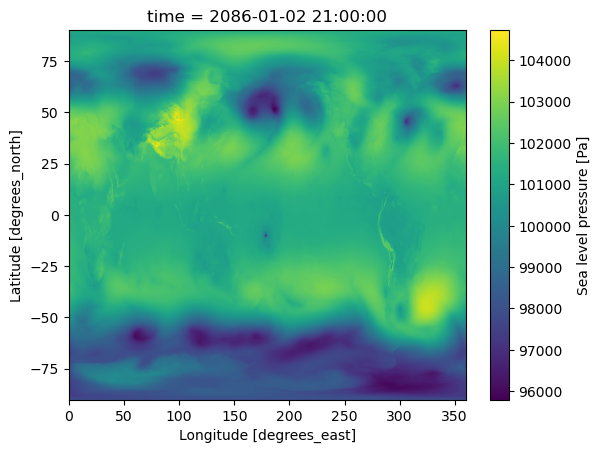

In [50]:
datacheck.PSL.isel(time=0).plot()

In [26]:
datacheck.PSL.isnull().sum().values

array(0)

In [34]:
datacheck.TMQ

<xarray.DataArray 'TMQ' (time: 1, lat: 768, lon: 1152)>
[884736 values with dtype=float32]
Coordinates:
  * time     (time) object 2086-01-02 21:00:00
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
Attributes:
    long_name:      Total (vertically integrated) precipitable water
    units:          kg/m2
    title:          3-hr averaged/vertically integrated/CESM Water Vapor
    summary:        Create input for ClimateNet application
    creator:        Teagan King, tking@ucar.edu
    contact:        Teagan King, tking@ucar.edu
    script:         jupyter notebook at /glade/u/home/tking/cgnet/Data_Proces...
    conventions:    CF 1.0
    creation_date:  2022-12-20

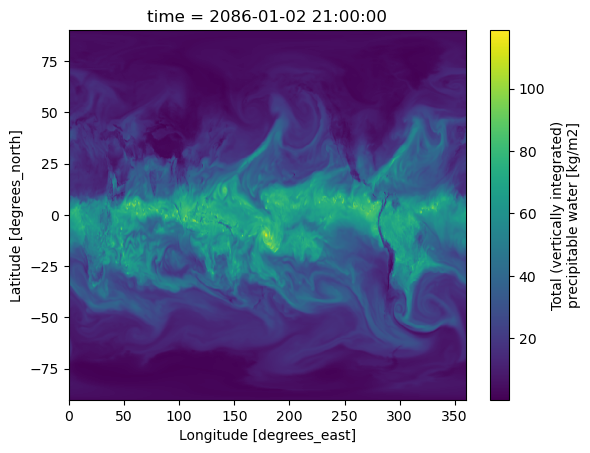

In [52]:
datacheck.TMQ.isel(time=0).plot()

In [25]:
datacheck.TMQ.isnull().sum().values

array(0)

In [7]:
datacheck.U850

<xarray.DataArray 'U850' (time: 1, lat: 768, lon: 1152)>
[884736 values with dtype=float32]
Coordinates:
  * time     (time) object 2086-01-02 21:00:00
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
Attributes:
    long_name:      Zonal wind at 850 mbar pressure surface
    units:          m/s
    mdims:          1
    cell_methods:   time: mean
    title:          3-hr averaged Zonal wind at 850 mbar pressure surface
    summary:        Create input for ClimateNet application
    creator:        Teagan King, tking@ucar.edu
    contact:        Teagan King, tking@ucar.edu
    script:         jupyter notebook at ML-extremes/notebooks/Data_Processing...
    conventions:    CF 1.0
    creation_date:  2023-02-17

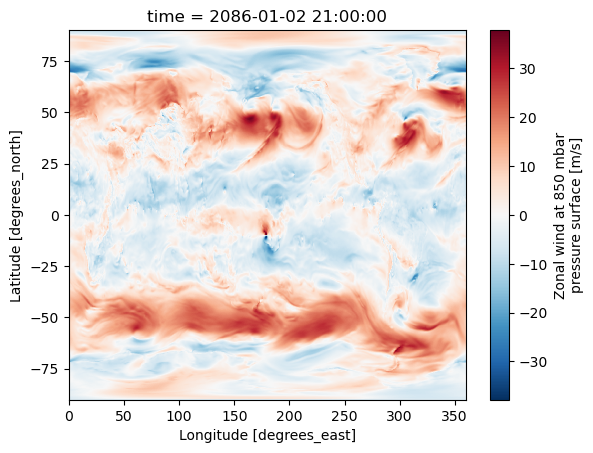

In [8]:
datacheck.U850.isel(time=0).plot()

In [23]:
datacheck.U850.isnull().sum().values

array(2)

In [32]:
datacheck.U850.where(datacheck.U850.isnull()==True, drop=True)

<xarray.DataArray 'U850' (time: 1, lat: 2, lon: 1)>
array([[[nan],
        [nan]]], dtype=float32)
Coordinates:
  * time     (time) object 2086-01-02 21:00:00
  * lat      (lat) float64 34.85 35.08
  * lon      (lon) float64 63.44
Attributes:
    long_name:      Zonal wind at 850 mbar pressure surface
    units:          m/s
    mdims:          1
    cell_methods:   time: mean
    title:          3-hr averaged Zonal wind at 850 mbar pressure surface
    summary:        Create input for ClimateNet application
    creator:        Teagan King, tking@ucar.edu
    contact:        Teagan King, tking@ucar.edu
    script:         jupyter notebook at ML-extremes/notebooks/Data_Processing...
    conventions:    CF 1.0
    creation_date:  2023-02-17

In [35]:
datacheck.V850

<xarray.DataArray 'V850' (time: 1, lat: 768, lon: 1152)>
[884736 values with dtype=float32]
Coordinates:
  * time     (time) object 2086-01-02 21:00:00
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
Attributes:
    long_name:      Meridional wind at 850 mbar pressure surface
    units:          m/s
    mdims:          1
    cell_methods:   time: mean
    title:          3-hr averaged Meridional wind at 850 mbar pressure surface
    summary:        Create input for ClimateNet application
    creator:        Teagan King, tking@ucar.edu
    contact:        Teagan King, tking@ucar.edu
    script:         jupyter notebook at ML-extremes/notebooks/Data_Processing...
    conventions:    CF 1.0
    creation_date:  2023-02-18

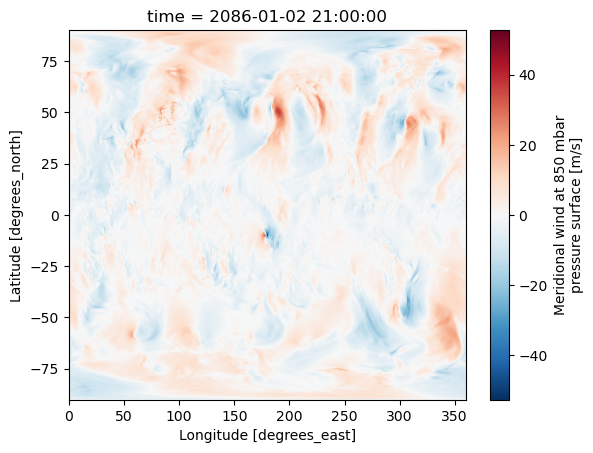

In [39]:
datacheck.V850.isel(time=0).plot()

In [35]:
datacheck.V850.isnull().sum().values

array(2)

In [33]:
datacheck.V850.where(datacheck.V850.isnull()==True, drop=True)

<xarray.DataArray 'V850' (time: 1, lat: 2, lon: 1)>
array([[[nan],
        [nan]]], dtype=float32)
Coordinates:
  * time     (time) object 2086-01-02 21:00:00
  * lat      (lat) float64 34.85 35.08
  * lon      (lon) float64 63.44
Attributes:
    long_name:      Meridional wind at 850 mbar pressure surface
    units:          m/s
    mdims:          1
    cell_methods:   time: mean
    title:          3-hr averaged Meridional wind at 850 mbar pressure surface
    summary:        Create input for ClimateNet application
    creator:        Teagan King, tking@ucar.edu
    contact:        Teagan King, tking@ucar.edu
    script:         jupyter notebook at ML-extremes/notebooks/Data_Processing...
    conventions:    CF 1.0
    creation_date:  2023-02-18

### SOLVED: Why is cgnet producing zero masks for certain time points?
Problem with missing values in U850 and V850 input fields.\
Update data processing to use raw U850/V850 output instead of interpolated.

## Global AR frequency maps

In [15]:
npercentARs_rcp85 = 100*((cnet_mask_rcp85.clip(min=1)-1).sum(dim='time'))/len(cnet_mask_rcp85.time)
#npercentARs.plot(robust=True);

In [16]:
npercentARs_rcp85 = npercentARs_rcp85.persist()

In [20]:
npercentARs_rcp85.max().values

array(44.75799087)

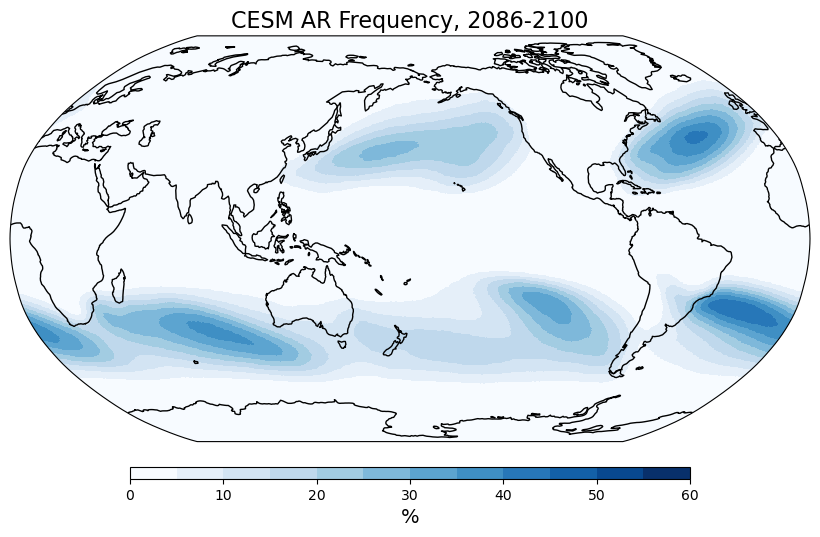

In [65]:
# a nicer plot
fig = plt.figure(figsize=(8,6))

cmap=plt.cm.get_cmap('Blues', 12)
vmax=60 # use the same value for hist/rcp2.6 to compare

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.Robinson(central_longitude=180.0))

lat = npercentARs_rcp85.lat
lon = npercentARs_rcp85.lon
pc = ax.pcolormesh(lon, lat, npercentARs_rcp85, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())

ax.coastlines()

# add colorbar
cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.02])
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
ax.set_title('CESM AR Frequency, 2086-2100', fontsize=16); 

#plt.savefig('../figures/toSCP/npercentARs_CESM_rcp85.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentARs_CESM_rcp85_unwgt.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentARs_CESM_rcp85_config.png', bbox_inches='tight')

In [33]:
# save the AR freq from the updated normalization values; then go read in the next set for comparison
npercentARs_rcp85_histconfig = npercentARs_rcp85

#### Compare impact of different normalization values

In [42]:
# rcp85 config values minus hist config values
npercentARs_rcpdiff = npercentARs_rcp85 - npercentARs_rcp85_histconfig

In [43]:
print(npercentARs_rcpdiff.min().values, npercentARs_rcpdiff.max().values)

-3.5730593607305945 15.251141552511417


NameError: name 'npercentARs_rcp85_histconfig' is not defined

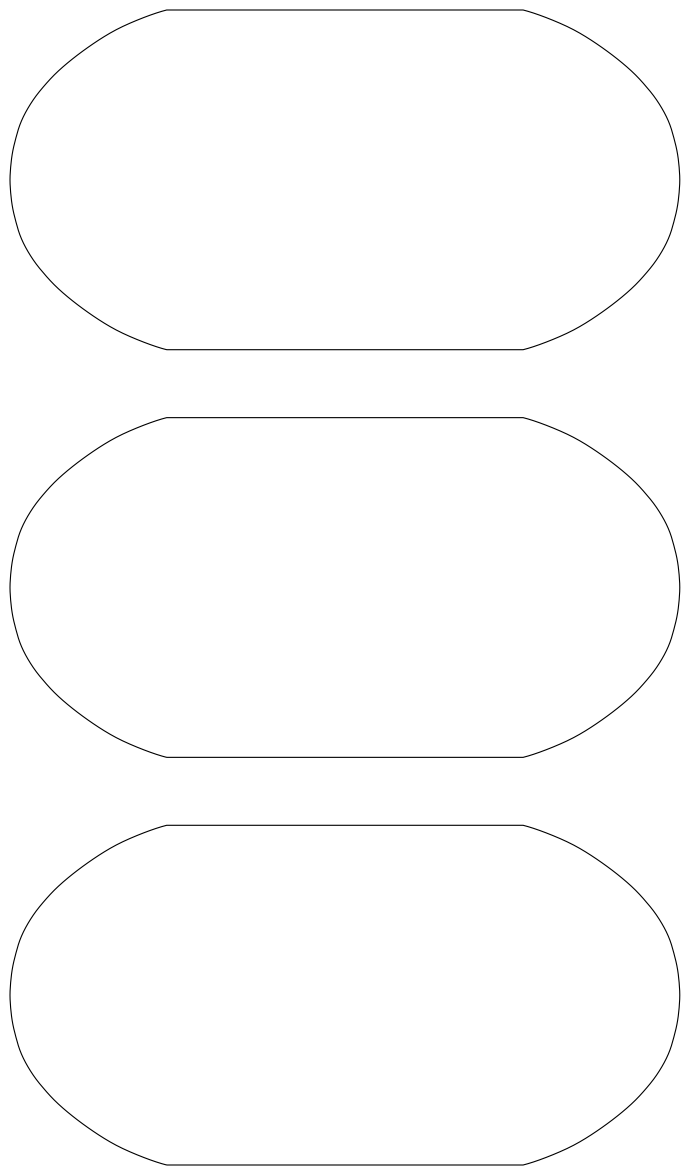

In [22]:
fig, axes = plt.subplots(3, 1, figsize=(12, 15), subplot_kw={'projection': ccrs.Robinson(central_longitude=180.0)})  # 3 rows, 1 column

cmap=plt.cm.get_cmap('Blues', 10)
vmax=50 

#cmap=plt.cm.get_cmap('Blues', 12)
#vmax=60

lat = npercentARs.lat
lon = npercentARs.lon

# Historical values
pc = axes[0].pcolormesh(lon, lat, npercentARs_rcp85_histconfig, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
axes[0].coastlines()
axes[0].set_title('Historical values')

# RCP8.5 values
pc = axes[1].pcolormesh(lon, lat, npercentARs_rcp85, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
axes[1].coastlines()
axes[1].set_title('RCP8.5 values')

# add colorbar
cbar_ax = fig.add_axes([0.85, 0.5, 0.02, 0.3]) #(left, bottom, width, height)
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='vertical')
cbar.ax.set_ylabel('%', fontsize=14)

# diff
cmap=plt.cm.get_cmap('seismic')
vmin=-15
vmax=15

pc = axes[2].pcolormesh(lon, lat, npercentARs_rcpdiff, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
axes[2].coastlines()
axes[2].set_title('RCP8.5 values minus historical values')

cbar_ax = fig.add_axes([0.85, 0.1, 0.02, 0.2]) #(left, bottom, width, height)
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='vertical', extend='max')
cbar.ax.set_ylabel('%', fontsize=14)

# add suptitle
fig.suptitle('AR Frequency\nImpact of climate state', fontsize=16, y=0.95)

plt.savefig('../figures/toSCP/npercentARs_CESM_rcpdiff.png', bbox_inches='tight')

### RCP8.5 - historical diff

In [18]:
npercentARs_diff = npercentARs_rcp85 - npercentARs

In [19]:
print(npercentARs_diff.max().values, npercentARs_diff.min().values)

9.666666666666664 -10.139269406392692


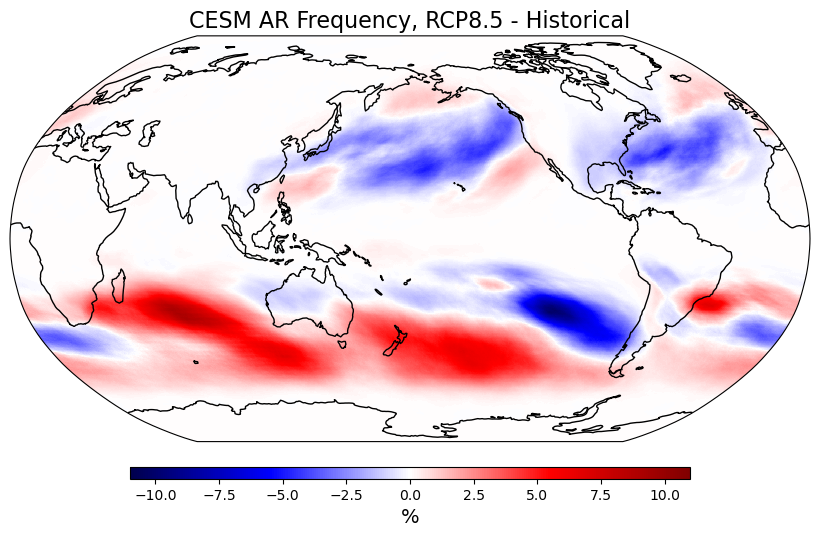

In [86]:
fig = plt.figure(figsize=(8,6))

cmap=plt.cm.get_cmap('seismic')
vmin=-11
vmax=11

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.Robinson(central_longitude=180.0))

lat = npercentARs_diff.lat
lon = npercentARs_diff.lon
pc = ax.pcolormesh(lon, lat, npercentARs_diff, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())

ax.coastlines()

# add colorbar
cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.02])
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
ax.set_title('CESM AR Frequency, RCP8.5 - Historical', fontsize=16); 

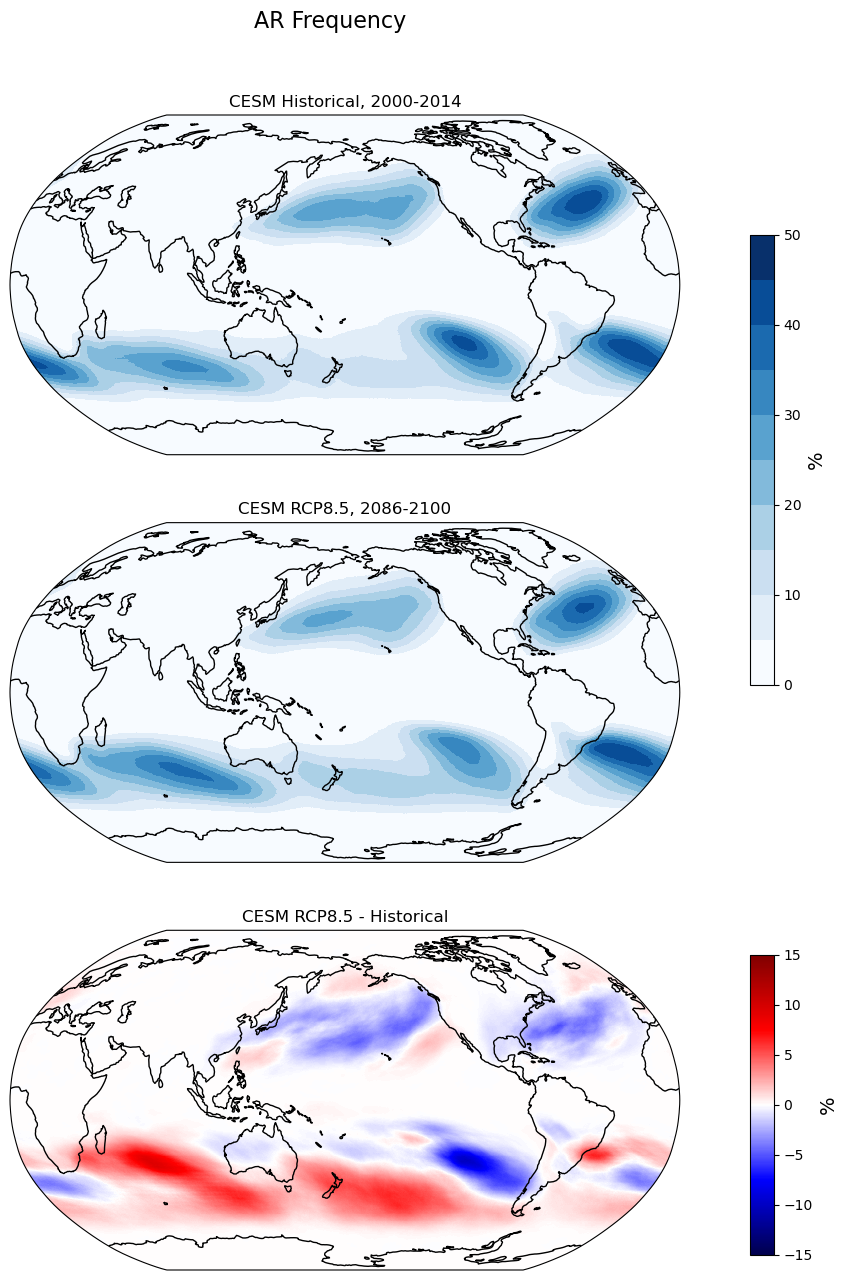

In [25]:
fig, axes = plt.subplots(3, 1, figsize=(12, 15), subplot_kw={'projection': ccrs.Robinson(central_longitude=180.0)})  # 3 rows, 1 column

cmap=plt.cm.get_cmap('Blues', 10)
vmax=50 

lat = npercentARs.lat
lon = npercentARs.lon

# CESM hist
pc = axes[0].pcolormesh(lon, lat, npercentARs, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
axes[0].coastlines()
axes[0].set_title('CESM Historical, 2000-2014')

# CESM RCP8.5
pc = axes[1].pcolormesh(lon, lat, npercentARs_rcp85, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
axes[1].coastlines()
axes[1].set_title('CESM RCP8.5, 2086-2100')

# add colorbar
cbar_ax = fig.add_axes([0.85, 0.5, 0.02, 0.3]) #(left, bottom, width, height)
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='vertical')
cbar.ax.set_ylabel('%', fontsize=14)

# diff
cmap=plt.cm.get_cmap('seismic')
vmin=-15
vmax=15

pc = axes[2].pcolormesh(lon, lat, npercentARs_diff, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
axes[2].coastlines()
axes[2].set_title('CESM RCP8.5 - Historical')

cbar_ax = fig.add_axes([0.85, 0.12, 0.02, 0.2]) #(left, bottom, width, height)
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='vertical')
cbar.ax.set_ylabel('%', fontsize=14)

# add suptitle
fig.suptitle('AR Frequency', fontsize=16, y=0.95)

#plt.savefig('../figures/toSCP/npercentARs_CESM_hist_rcp85.png', bbox_inches='tight')

### Global TC frequency masks
Note: release the ``npercentARs`` variable from memory so the ``npercentTCs`` processing doesn't run out of memory (or increase the dask request)

In [37]:
del npercentARs

In [38]:
# can't figure out how to use .clip to select TCs
npercentTCs = 100*(cnet_mask.where(cnet_mask==1).sum(dim='time'))/len(cnet_mask.time)

In [39]:
npercentTCs = npercentTCs.persist()

In [40]:
npercentTCs.max().values

array(12.04794521)

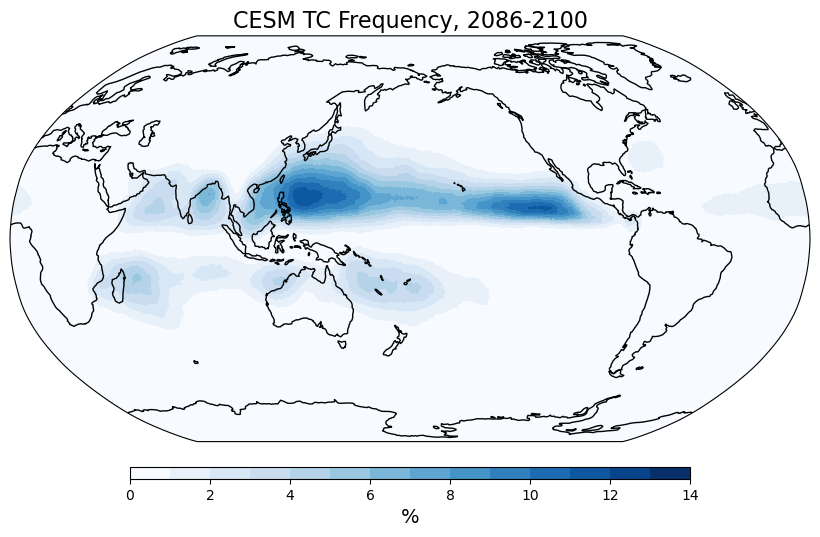

In [41]:
# a nicer plot
fig = plt.figure(figsize=(8,6))

cmap=plt.cm.get_cmap('Blues', 14)
vmax=14 # use the same value for hist/rcp2.6 to compare

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.Robinson(central_longitude=180.0))

lat = npercentTCs.lat
lon = npercentTCs.lon
pc = ax.pcolormesh(lon, lat, npercentTCs, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())

ax.coastlines()

# add colorbar
cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.02])
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal')
#cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal', extend='max')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
ax.set_title('CESM TC Frequency, 2086-2100', fontsize=16);

#plt.savefig('../figures/toSCP/npercentTCs_CESM_rcp85.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentTCs_CESM_rcp85_unwgt.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentTCs_CESM_rcp85_config.png', bbox_inches='tight')

In [24]:
del npercentTCs

## TO DO: spot check detected events with underlying CESM fields for each simulation/time period
Are the ARs and TCs in the right place(s)?\
How would we check this systematically? One way could be to composite the underlying fields (e.g., TMQ) across the times where there is an AR detected.\
Could also use the information from the underlying fields to determine an event "center" e.g., for TCs.

## MERRA ARs

In [26]:
merra_cnet_path = '/glade/derecho/scratch/shields/ARTMIP/catalogues/tier1/ClimateNet_DL/' # tier1, 3hrly
#merra_cnet_path_t2 = '/glade/derecho/scratch/shields/ARTMIP/catalogues/tier2/MERRA2_native/climatenet/' # tier2, 1hrly

In [27]:
file_years = '*.20[00-15]*' # not a perfect wildcard, but captures 2000 - 2017 (or 2019 for tier2)
#file_years = '*.nc4' # for all years; 1980 - June 2017

### Preprocessing function to (optionally) subset regionally

In [6]:
# MERRA2 lons are -180 / +180
lat_bounds_merra = slice(32,55)
lon_bounds_merra = slice(-130,-105)

In [7]:
def preprocess_region_merra(ds):
    # return regional domain
    return ds['ar_binary_tag'].sel(lat=lat_bounds_merra,lon=lon_bounds_merra)

### Read in data

In [28]:
merra_cnet = xr.open_mfdataset(merra_cnet_path+file_years, concat_dim='time', combine='nested', chunks={'time':500}, parallel=True)
#merra_cnet = xr.open_mfdataset(merra_cnet_path+file_years, concat_dim='time', combine='nested', chunks={'time':500}, parallel=True, preprocess=preprocess_region_merra)
#merra_cnet

In [ ]:
merra_cnet_t2 = xr.open_mfdataset(merra_cnet_path_t2+file_years, concat_dim='time', combine='nested', chunks={'time':500}, parallel=True)
#merra_cnet_t2

In [29]:
# if not using preprocess
merra_ar_full = merra_cnet.ar_binary_tag

#merra_ar_full = merra_cnet
#merra_ar_full

In [12]:
merra_ar_full_t2 = merra_cnet_t2.ar_binary_tag

In [30]:
# subset 2000-2014(5) to match CESM years (number of time indices will not match due to CESM shifted start and MERRA leap years)
#merra_ar = merra_ar_full.sel(time=slice("2000","2015"))
merra_ar = merra_ar_full.sel(time=slice("2000","2014"))

# or look at all years
#merra_ar = merra_ar_full

merra_ar

<xarray.DataArray 'ar_binary_tag' (time: 43832, lat: 361, lon: 576)>
dask.array<getitem, shape=(43832, 361, 576), dtype=int8, chunksize=(500, 361, 576), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float32 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time     (time) datetime64[ns] 2000-01-01 ... 2014-12-31T21:00:00
Attributes:
    version:      CGNet
    scheme:       ClimateNet_DL_model
    description:  binary indicator of atmospheric river

In [14]:
merra_ar_t2 = merra_ar_full_t2.sel(time=slice("2000","2014"))
merra_ar_t2

<xarray.DataArray 'ar_binary_tag' (time: 131496, lat: 361, lon: 576)>
dask.array<getitem, shape=(131496, 361, 576), dtype=int8, chunksize=(500, 361, 576), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float32 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time     (time) datetime64[ns] 2000-01-01T00:30:00 ... 2014-12-31T23:30:00
Attributes:
    description:  binary indicator of atmospheric river
    scheme:       ClimateNet_DL_model
    version:      CGNet

#### NOTE: why are these MERRA ARs on a 0.5deg grid? What was the resolution used for input to CGNet?
Update: they were apparently run on the native grid

In [31]:
npercentARs_merra = 100*(merra_ar.sum(dim='time'))/len(merra_ar.time)

In [32]:
npercentARs_merra = npercentARs_merra.persist()

In [33]:
npercentARs_merra.max().values

array(47.86457383)

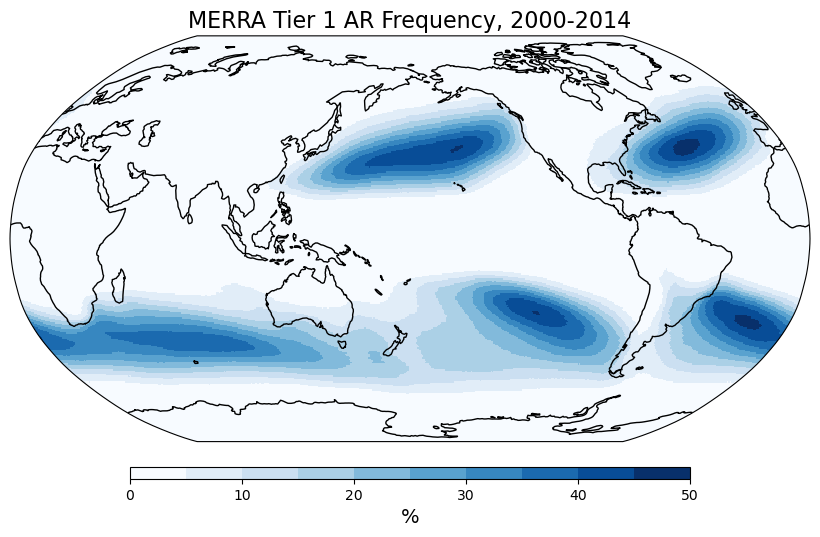

In [31]:
# a nicer plot
fig = plt.figure(figsize=(8,6))

cmap=plt.cm.get_cmap('Blues', 10)
vmax=50

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.Robinson(central_longitude=180.0))

lat = npercentARs_merra.lat
lon = npercentARs_merra.lon
pc = ax.pcolormesh(lon, lat, npercentARs_merra, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())

ax.coastlines()

# add colorbar
cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.02])
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal')
#cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal', extend='max')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
#ax.set_title('MERRA AR Frequency, 2000-2015', fontsize=16); 
ax.set_title('MERRA Tier 1 AR Frequency, 2000-2014', fontsize=16); 

#plt.savefig('../figures/toSCP/npercentARs_MERRA2_tier1_2000-2015.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentARs_MERRA2_tier1_2000-2014.png', bbox_inches='tight')

In [19]:
npercentARs_merra_t2 = 100*(merra_ar_t2.sum(dim='time'))/len(merra_ar_t2.time)

In [20]:
npercentARs_merra_t2 = npercentARs_merra_t2.persist()

In [21]:
npercentARs_merra_t2.max().values

array(49.33990388)

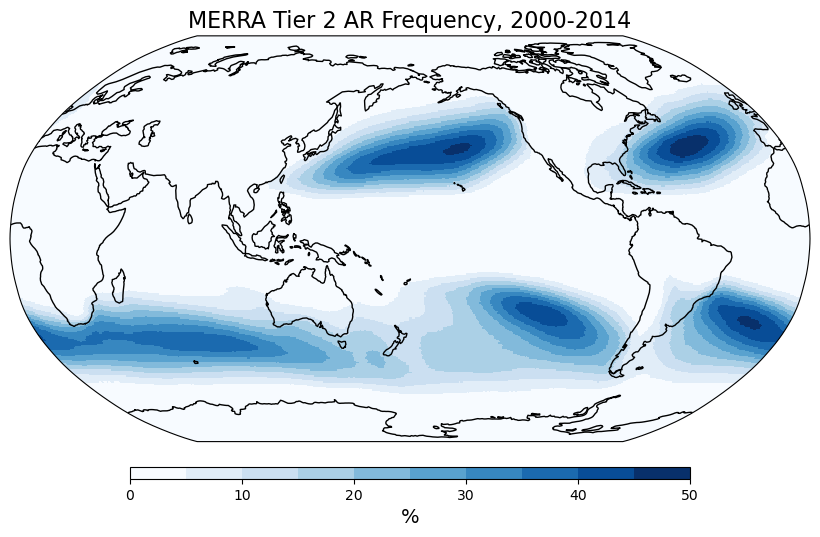

In [32]:
# a nicer plot
fig = plt.figure(figsize=(8,6))

cmap=plt.cm.get_cmap('Blues', 10)
vmax=50

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.Robinson(central_longitude=180.0))

lat = npercentARs_merra_t2.lat
lon = npercentARs_merra_t2.lon
pc = ax.pcolormesh(lon, lat, npercentARs_merra_t2, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())

ax.coastlines()

# add colorbar
cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.02])
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal')
#cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal', extend='max')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
ax.set_title('MERRA Tier 2 AR Frequency, 2000-2014', fontsize=16); 

#plt.savefig('../figures/toSCP/npercentARs_MERRA2_tier2_2000-2014.png', bbox_inches='tight')

### MERRA Tier 1 / Tier 2 differences

In [24]:
npercentARs_merra_tierdiff = npercentARs_merra - npercentARs_merra_t2 # Tier 1 minus Tier 2

In [25]:
npercentARs_merra_tierdiff

<xarray.DataArray 'ar_binary_tag' (lat: 361, lon: 576)>
dask.array<sub, shape=(361, 576), dtype=float64, chunksize=(361, 576), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float32 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4

In [34]:
print(npercentARs_merra_tierdiff.min().values, npercentARs_merra_tierdiff.max().values)

-2.133905213846809 4.404696720812797


Text(0.5, 0.95, 'MERRA AR Frequency')

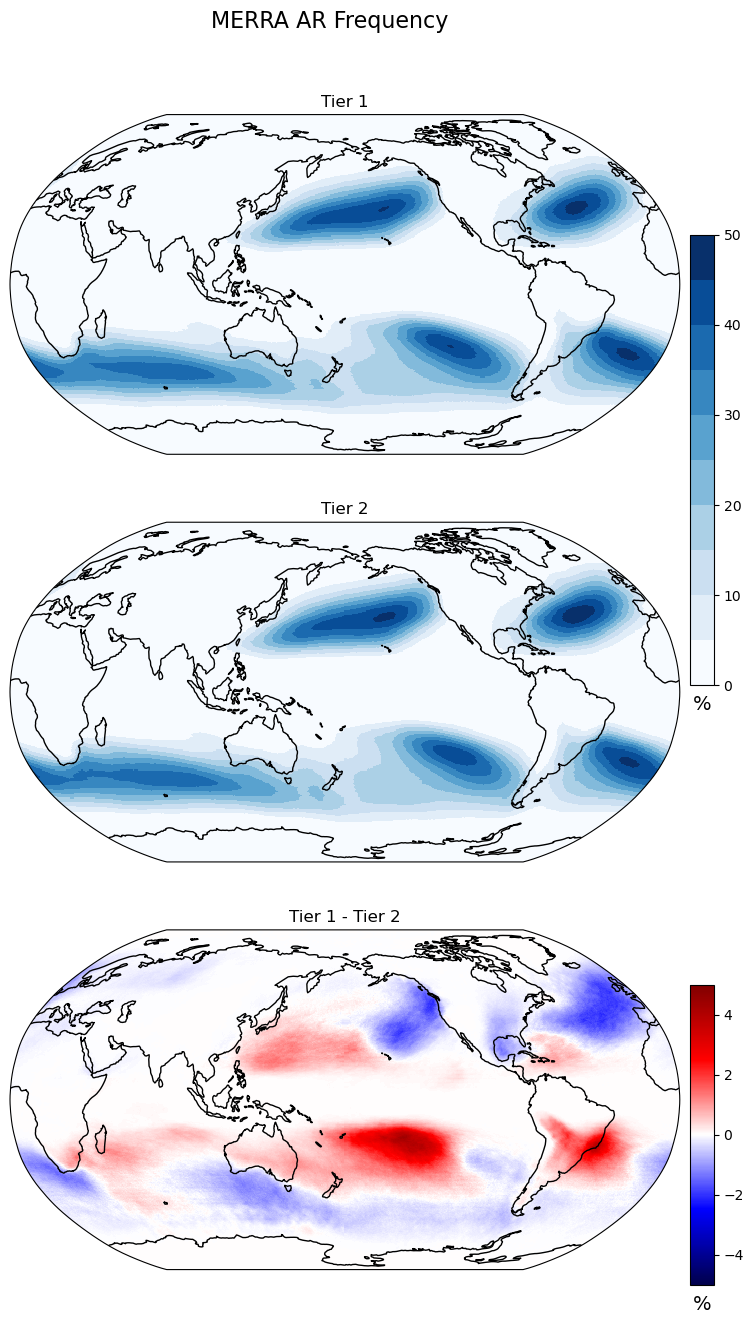

In [35]:
fig, axes = plt.subplots(3, 1, figsize=(12, 15), subplot_kw={'projection': ccrs.Robinson(central_longitude=180.0)})  # 3 rows, 1 column

cmap=plt.cm.get_cmap('Blues', 10)
vmax=50

lat = npercentARs_merra.lat
lon = npercentARs_merra.lon

# tier 1
pc = axes[0].pcolormesh(lon, lat, npercentARs_merra, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
axes[0].coastlines()
axes[0].set_title('Tier 1')

# tier 2
pc = axes[1].pcolormesh(lon, lat, npercentARs_merra_t2, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
axes[1].coastlines()
axes[1].set_title('Tier 2')

# add colorbar
cbar_ax = fig.add_axes([0.8, 0.5, 0.02, 0.3]) #(left, bottom, width, height)
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='vertical')
cbar.ax.set_xlabel('%', fontsize=14)

# diff
cmap=plt.cm.get_cmap('seismic')
vmin=-5
vmax=5
pc = axes[2].pcolormesh(lon, lat, npercentARs_merra_tierdiff, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
axes[2].coastlines()
axes[2].set_title('Tier 1 - Tier 2')

cbar_ax = fig.add_axes([0.8, 0.1, 0.02, 0.2]) #(left, bottom, width, height)
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='vertical')
cbar.ax.set_xlabel('%', fontsize=14)

# add suptitle
fig.suptitle('MERRA AR Frequency', fontsize=16, y=0.95)

## Remap CESM to MERRA grid to calculate diffs
Tried remapping the underlying masks first and then calculating npercentARs again instead of remapping that, but remapping the masks results in spotting in data. Not exactly sure why, maybe something to do with the binary field. Might actually be better to remap the downstream npercentARs fields.\
Use `periodic=True` in regridder to avoid missing data on prime meridian.

### Try translating longitudes before regridding
To avoid missing data along dateline...doesn't really work

In [67]:
# translate longitudes of masks to match MERRA before regridding (trying to avoid aliasing along dateline...doesn't work)
cnet_mask_lon = cnet_mask
cnet_mask_lon.coords['lon'] = (cnet_mask_lon.coords['lon'] + 180) % 360 - 180
cnet_mask_lon = cnet_mask_lon.sortby(cnet_mask_lon.lon)
npercentARs_lon = 100*((cnet_mask_lon.clip(min=1)-1).sum(dim='time'))/len(cnet_mask_lon.time)

In [54]:
# translate longitudes of npercentARs to match MERRA before regridding (trying to avoid aliasing along dateline...doesn't work)
npercentARs_lon = npercentARs
npercentARs_lon.coords['lon'] = (npercentARs_lon.coords['lon'] + 180) % 360 - 180
npercentARs_lon = npercentARs_lon.sortby(npercentARs_lon.lon)
npercentARs_lon

<xarray.DataArray 'masks' (lat: 768, lon: 1152)>
dask.array<getitem, shape=(768, 1152), dtype=float64, chunksize=(768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -180.0 -179.7 -179.4 -179.1 ... 179.1 179.4 179.7
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0

### Regridding

In [34]:
%%time
#regridder = xe.Regridder(cnet_mask, merra_ar, "bilinear")
#regridder = xe.Regridder(npercentARs_lon, npercentARs_merra, "bilinear", periodic=True)
regridder = xe.Regridder(npercentARs, npercentARs_merra, "bilinear", periodic=True)
regridder

CPU times: user 13.9 s, sys: 474 ms, total: 14.3 s
Wall time: 13.1 s


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_768x1152_361x576_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (768, 1152) 
Output grid shape:          (361, 576) 
Periodic in longitude?      True

In [35]:
%%time
#npercentARs_merragrid = regridder(npercentARs_lon, keep_attrs=True)
npercentARs_merragrid = regridder(npercentARs, keep_attrs=True)
npercentARs_merragrid

CPU times: user 2.03 s, sys: 85.8 ms, total: 2.12 s
Wall time: 3.03 s


<xarray.DataArray 'masks' (lat: 361, lon: 576)>
dask.array<_regrid, shape=(361, 576), dtype=float64, chunksize=(361, 576), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float32 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
Attributes:
    regrid_method:  bilinear

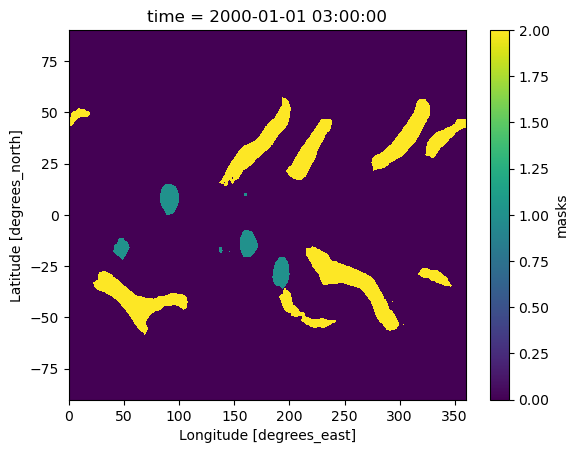

In [40]:
cnet_mask.isel(time=0).plot()

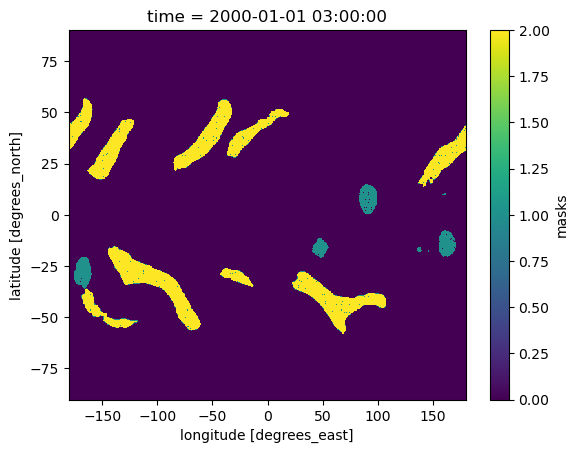

In [35]:
cnet_mask_merragrid.isel(time=0).plot()

In [31]:
npercentARs_merragrid = 100*((cnet_mask_merragrid.clip(min=1)-1).sum(dim='time'))/len(cnet_mask_merragrid.time)

In [36]:
npercentARs_merragrid = npercentARs_merragrid.persist()

In [37]:
npercentARs_merragrid.max().values

array(44.65905638)

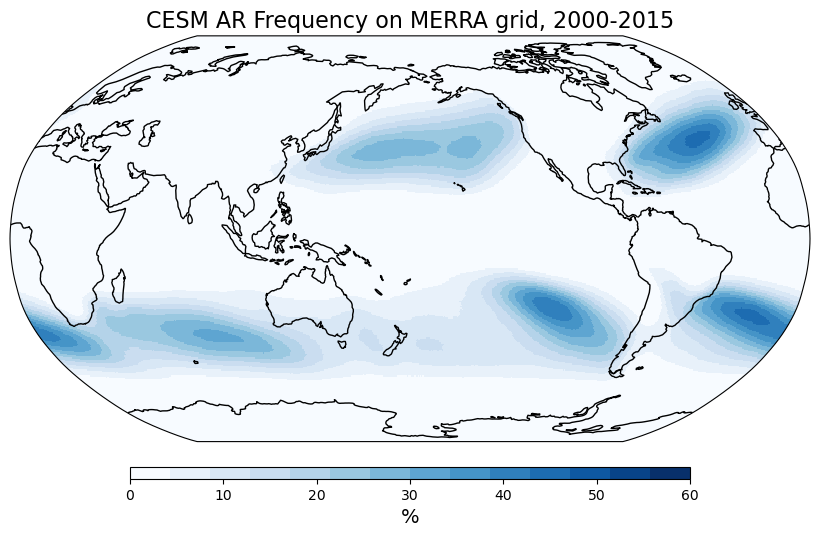

In [81]:
# a nicer plot
fig = plt.figure(figsize=(8,6))

cmap=plt.cm.get_cmap('Blues', 14)
vmax=60 # use the same value for hist/rcp2.6 to compare

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.Robinson(central_longitude=180.0))

lat = npercentARs_merragrid.lat
lon = npercentARs_merragrid.lon
pc = ax.pcolormesh(lon, lat, npercentARs_merragrid, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())

ax.coastlines()

# add colorbar
cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.02])
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal')
#cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal', extend='max')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
ax.set_title('CESM AR Frequency on MERRA grid, 2000-2015', fontsize=16);

In [38]:
npercentARs_merra_diff = npercentARs_merra - npercentARs_merragrid

In [39]:
print(npercentARs_merra_diff.max().values, npercentARs_merra_diff.min().values)

20.516173183959722 -10.96279187609376


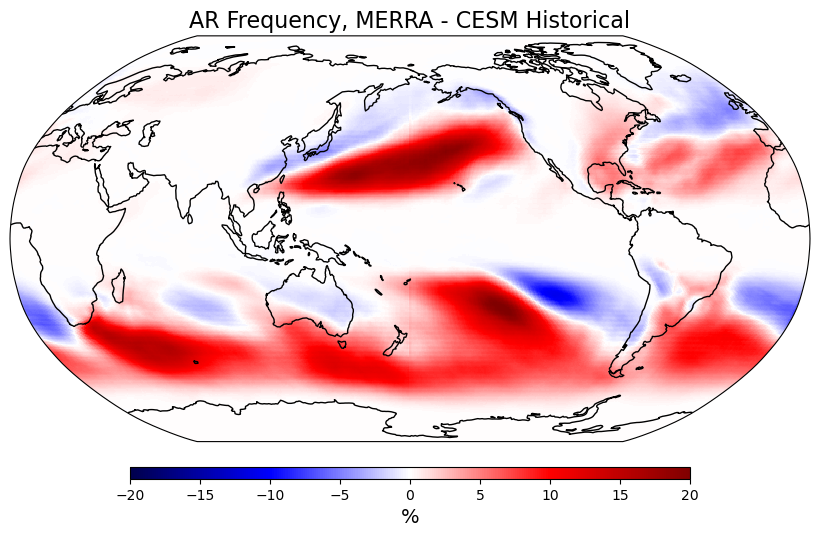

In [27]:
fig = plt.figure(figsize=(8,6))

cmap=plt.cm.get_cmap('seismic')
vmin=-20
vmax=20

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.Robinson(central_longitude=180.0))

lat = npercentARs_merra_diff.lat
lon = npercentARs_merra_diff.lon
pc = ax.pcolormesh(lon, lat, npercentARs_merra_diff, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())

ax.coastlines()

# add colorbar
cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.02])
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
ax.set_title('AR Frequency, MERRA - CESM Historical', fontsize=16); 

## Panel plot with CESM hist, RCP8.5, and MERRA global frequency maps

In [38]:
print('Absolute max values are ', npercentARs.max().values, npercentARs_rcp85.max().values, npercentARs_merra.max().values)

Absolute max values are  44.6986301369863 44.757990867579906 47.864573827340756


In [39]:
print('Diff min values are ', npercentARs_diff.min().values, npercentARs_merra_diff.min().values)
print('Diff max values are ', npercentARs_diff.max().values, npercentARs_merra_diff.max().values)

Diff min values are  -10.139269406392692 -10.96279187609376
Diff max values are  9.666666666666664 20.516173183959722


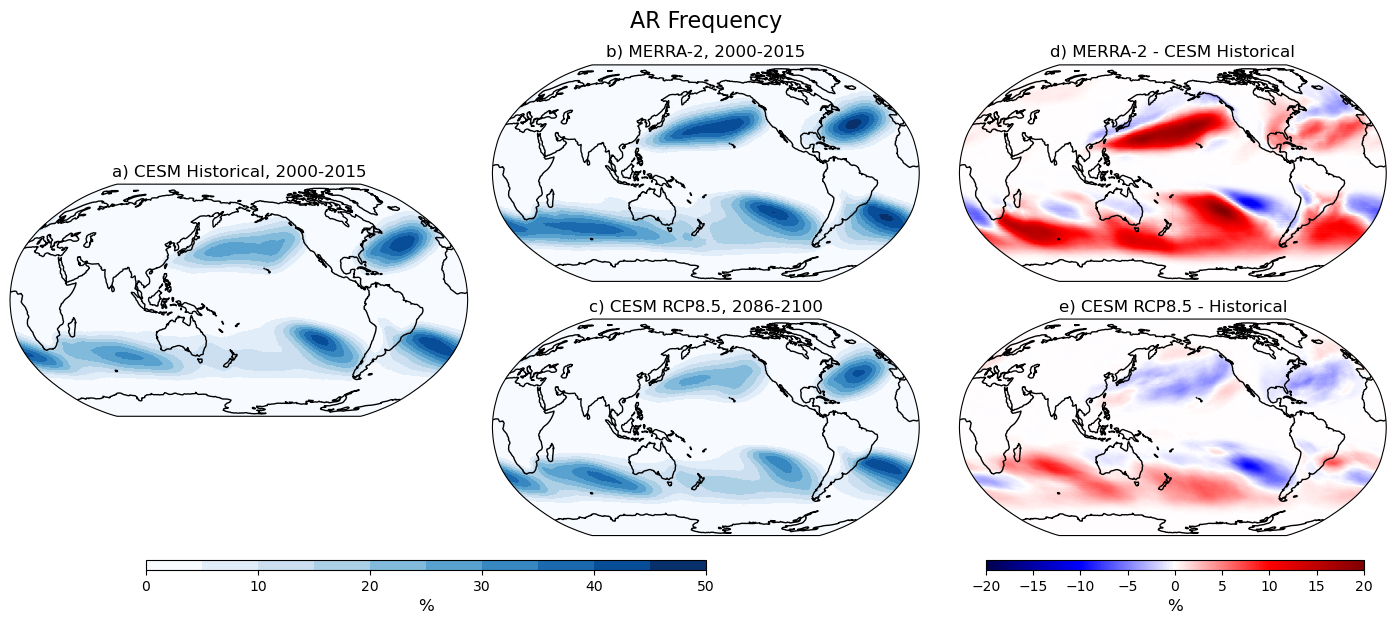

In [41]:
#fig, ax = plt.subplots(2, 3, figsize=(14,8), subplot_kw={'projection': ccrs.Robinson(central_longitude=180.0)}) # figsize is width, height
fig, ax = plt.subplot_mosaic([['left', 'upper middle', 'upper right'],
                               ['left', 'lower middle', 'lower right']],
                              figsize=(14,5), layout="constrained",
                              subplot_kw={'projection': ccrs.Robinson(central_longitude=180.0)})

# colormap/scale for absolute plots
cmap=plt.cm.get_cmap('Blues', 10)
vmax=50

# CESM Hist
lat = npercentARs.lat
lon = npercentARs.lon
pc = ax['left'].pcolormesh(lon, lat, npercentARs, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
ax['left'].coastlines()
ax['left'].set_title('a) CESM Historical, 2000-2015', fontsize=12)

# MERRA
lat = npercentARs_merra.lat
lon = npercentARs_merra.lon
pc = ax['upper middle'].pcolormesh(lon, lat, npercentARs_merra, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
ax['upper middle'].coastlines()
ax['upper middle'].set_title('b) MERRA-2, 2000-2015', fontsize=12)

# CESM RCP8.5
lat = npercentARs_rcp85.lat
lon = npercentARs_rcp85.lon
pc = ax['lower middle'].pcolormesh(lon, lat, npercentARs_rcp85, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
ax['lower middle'].coastlines()
ax['lower middle'].set_title('c) CESM RCP8.5, 2086-2100', fontsize=12)

# add colorbar for absolute plots
cbar_ax = fig.add_axes([0.1, -0.06, 0.4, 0.02]) #(left, bottom, width, height)
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal')
cbar.ax.set_xlabel('%', fontsize=12)

# colormap/scale for diff plots
cmap=plt.cm.get_cmap('seismic')
vmin=-20
vmax=20

# MERRA - Hist
lat = npercentARs_merra_diff.lat
lon = npercentARs_merra_diff.lon
pc = ax['upper right'].pcolormesh(lon, lat, npercentARs_merra_diff, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
ax['upper right'].coastlines()
ax['upper right'].set_title('d) MERRA-2 - CESM Historical', fontsize=12)

# RCP - Hist
lat = npercentARs_diff.lat
lon = npercentARs_diff.lon
pc = ax['lower right'].pcolormesh(lon, lat, npercentARs_diff, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
ax['lower right'].coastlines()
ax['lower right'].set_title('e) CESM RCP8.5 - Historical', fontsize=12)

# add colorbar
cbar_ax = fig.add_axes([0.7, -0.06, 0.27, 0.02])
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal')
cbar.ax.set_xlabel('%', fontsize=12);

# add suptitle
fig.suptitle('AR Frequency', fontsize=16, y=1.06)

#plt.subplots_adjust(wspace=0.1, hspace=0) # can't use with subplot_mosaic

#plt.savefig('../figures/toSCP/npercentARs_CESM_hist_rcp85_merra_diffs.png', dpi=300, bbox_inches='tight')

A different paneling strategy

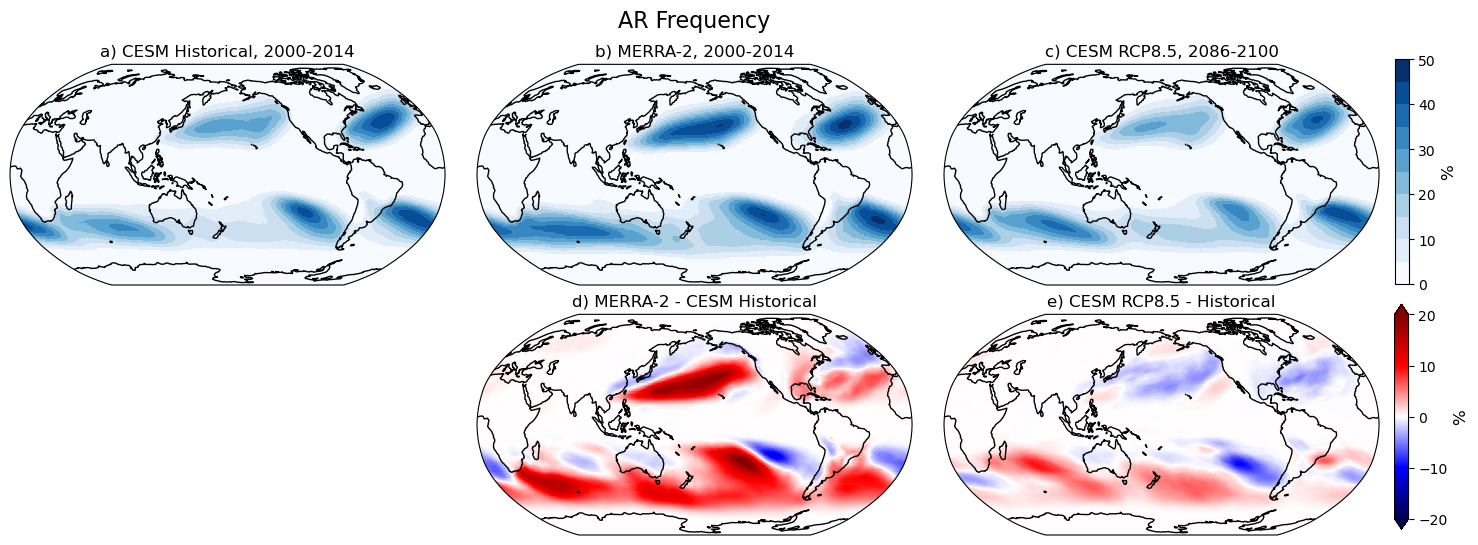

In [43]:
#fig, ax = plt.subplots(2, 3, figsize=(14,8), subplot_kw={'projection': ccrs.Robinson(central_longitude=180.0)}) # figsize is width, height
fig, ax = plt.subplot_mosaic([['upper left', 'upper middle', 'upper right'],
                               ['X', 'lower middle', 'lower right']], empty_sentinel='X',
                              figsize=(14,5), layout="constrained",
                              subplot_kw={'projection': ccrs.Robinson(central_longitude=180.0)})

# colormap/scale for absolute plots
cmap=plt.cm.get_cmap('Blues', 10)
vmax=50

# CESM Hist
lat = npercentARs.lat
lon = npercentARs.lon
pc = ax['upper left'].pcolormesh(lon, lat, npercentARs, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
ax['upper left'].coastlines()
ax['upper left'].set_title('a) CESM Historical, 2000-2014', fontsize=12)

# MERRA
lat = npercentARs_merra.lat
lon = npercentARs_merra.lon
pc = ax['upper middle'].pcolormesh(lon, lat, npercentARs_merra, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
ax['upper middle'].coastlines()
ax['upper middle'].set_title('b) MERRA-2, 2000-2014', fontsize=12)

# CESM RCP8.5
lat = npercentARs_rcp85.lat
lon = npercentARs_rcp85.lon
pc = ax['upper right'].pcolormesh(lon, lat, npercentARs_rcp85, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
ax['upper right'].coastlines()
ax['upper right'].set_title('c) CESM RCP8.5, 2086-2100', fontsize=12)

# add colorbar for absolute plots
cbar_ax = fig.add_axes([1.0, 0.51, 0.01, 0.45]) #(left, bottom, width, height)
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='vertical')
cbar.ax.set_ylabel('%', fontsize=12)

# colormap/scale for diff plots
cmap=plt.cm.get_cmap('seismic')
vmin=-20
vmax=20

# MERRA - Hist
lat = npercentARs_merra_diff.lat
lon = npercentARs_merra_diff.lon
pc = ax['lower middle'].pcolormesh(lon, lat, npercentARs_merra_diff, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
ax['lower middle'].coastlines()
ax['lower middle'].set_title('d) MERRA-2 - CESM Historical', fontsize=12)

# RCP - Hist
lat = npercentARs_diff.lat
lon = npercentARs_diff.lon
pc = ax['lower right'].pcolormesh(lon, lat, npercentARs_diff, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
ax['lower right'].coastlines()
ax['lower right'].set_title('e) CESM RCP8.5 - Historical', fontsize=12)

# add colorbar
cbar_ax = fig.add_axes([1.0, 0.02, 0.01, 0.45])
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='vertical', extend='both')
cbar.ax.set_ylabel('%', fontsize=12);

# add suptitle
fig.suptitle('AR Frequency', fontsize=16, y=1.06);

#plt.subplots_adjust(wspace=0.1, hspace=0) # can't use with subplot_mosaic

#plt.savefig('../figures/toSCP/npercentARs_CESM_hist_rcp85_merra_diffs.png', dpi=300, bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentARs_CESM_hist_rcp85_merra_diffs_v2.png', dpi=600, bbox_inches='tight')

No RCP8.5 in panel plot

In [40]:
print('Absolute max values are ', npercentARs.max().values, npercentARs_merra.max().values)

Absolute max values are  44.6986301369863 47.864573827340756


In [41]:
print('Diff min values are ', npercentARs_merra_diff.min().values)
print('Diff max values are ', npercentARs_merra_diff.max().values)

Diff min values are  -10.96279187609376
Diff max values are  20.516173183959722


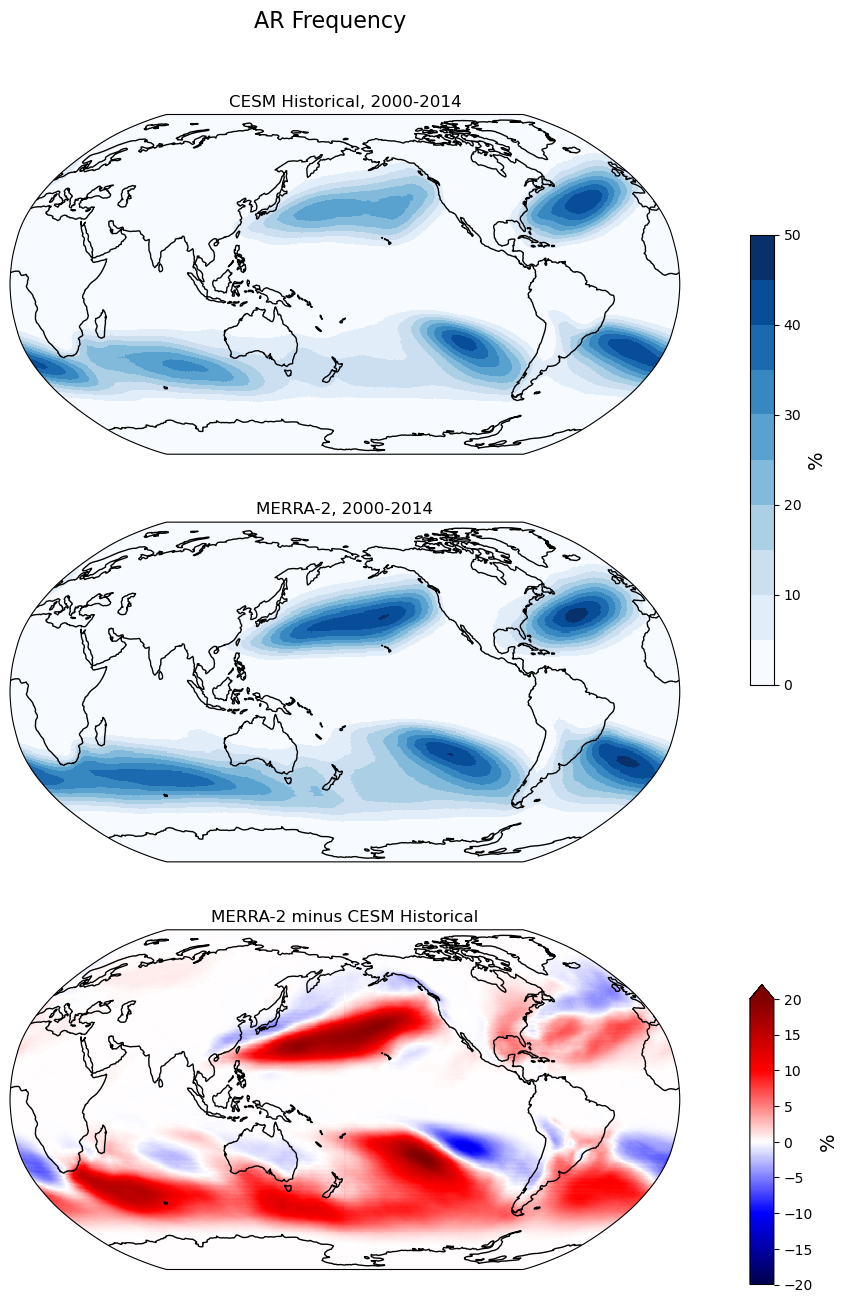

In [43]:
fig, axes = plt.subplots(3, 1, figsize=(12, 15), subplot_kw={'projection': ccrs.Robinson(central_longitude=180.0)})  # 3 rows, 1 column

cmap=plt.cm.get_cmap('Blues', 10)
vmax=50 

lat = npercentARs.lat
lon = npercentARs.lon

# Historical CESM
pc = axes[0].pcolormesh(lon, lat, npercentARs, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
axes[0].coastlines()
axes[0].set_title('CESM Historical, 2000-2014')

# MERRA
lat = npercentARs_merra.lat
lon = npercentARs_merra.lon
pc = axes[1].pcolormesh(lon, lat, npercentARs_merra, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
axes[1].coastlines()
axes[1].set_title('MERRA-2, 2000-2014')

# add colorbar
cbar_ax = fig.add_axes([0.85, 0.5, 0.02, 0.3]) #(left, bottom, width, height)
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='vertical')
cbar.ax.set_ylabel('%', fontsize=14)

# diff
cmap=plt.cm.get_cmap('seismic')
vmin=-20
vmax=20

lat = npercentARs_merra_diff.lat
lon = npercentARs_merra_diff.lon
pc = axes[2].pcolormesh(lon, lat, npercentARs_merra_diff, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
axes[2].coastlines()
axes[2].set_title('MERRA-2 minus CESM Historical')

cbar_ax = fig.add_axes([0.85, 0.1, 0.02, 0.2]) #(left, bottom, width, height)
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='vertical', extend='max')
cbar.ax.set_ylabel('%', fontsize=14)

# add suptitle
fig.suptitle('AR Frequency', fontsize=16, y=0.95)

#plt.savefig('../figures/toSCP/npercentARs_CESM_hist_merra.png', bbox_inches='tight')

## ERA5 ARs

In [36]:
era_cnet_path = '/glade/campaign/collections/rda/data/d651018/catalogues/ERA5/climatenet/' # tier2, 1hrly, 0.25deg

In [37]:
#file_years = '*.20[00-15]*' # can't figure out how to subset more than 2000-2019 which is the entire dataset anyway
file_years = '*.nc'

### Preprocessing function to (optionally) subset regionally

In [6]:
# MERRA2 lons are -180 / +180
lat_bounds_merra = slice(32,55)
lon_bounds_merra = slice(-130,-105)

In [7]:
def preprocess_region_merra(ds):
    # return regional domain
    return ds['ar_binary_tag'].sel(lat=lat_bounds_merra,lon=lon_bounds_merra)

### Read in data

In [38]:
era_cnet = xr.open_mfdataset(era_cnet_path+file_years, concat_dim='time', combine='nested', chunks={'time':500}, parallel=True)
#era_cnet

In [39]:
# if not using preprocess
era_ar_full = era_cnet.ar_binary_tag

#era_ar_full = era_cnet
era_ar_full

<xarray.DataArray 'ar_binary_tag' (time: 175320, lat: 721, lon: 1440)>
dask.array<concatenate, shape=(175320, 721, 1440), dtype=int8, chunksize=(500, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * time     (time) datetime64[ns] 2000-01-01 ... 2019-12-31T23:00:00
Attributes:
    description:  binary indicator of atmospheric river
    scheme:       ClimateNet_DL_model
    version:      CGNet

In [40]:
# subset 2000-2014(5) to match CESM years (number of time indices will not match due to CESM shifted start and ERA leap years)
#era_ar = era_ar_full.sel(time=slice("2000","2015"))
era_ar = era_ar_full.sel(time=slice("2000","2014"))

# or look at all years
#era_ar = era_ar_full

era_ar

<xarray.DataArray 'ar_binary_tag' (time: 131496, lat: 721, lon: 1440)>
dask.array<getitem, shape=(131496, 721, 1440), dtype=int8, chunksize=(500, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * time     (time) datetime64[ns] 2000-01-01 ... 2014-12-31T23:00:00
Attributes:
    description:  binary indicator of atmospheric river
    scheme:       ClimateNet_DL_model
    version:      CGNet

In [41]:
npercentARs_era = 100*(era_ar.sum(dim='time'))/len(era_ar.time)

In [42]:
npercentARs_era = npercentARs_era.persist()

In [43]:
npercentARs_era.max().values

array(42.65300846)

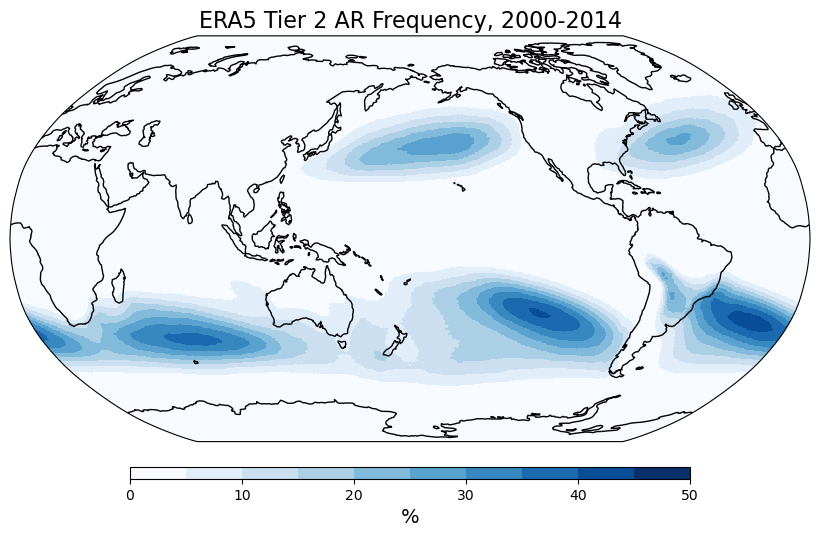

In [44]:
# a nicer plot
fig = plt.figure(figsize=(8,6))

cmap=plt.cm.get_cmap('Blues', 10)
vmax=50

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.Robinson(central_longitude=180.0))

lat = npercentARs_era.lat
lon = npercentARs_era.lon
pc = ax.pcolormesh(lon, lat, npercentARs_era, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())

ax.coastlines()

# add colorbar
cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.02])
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal')
#cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal', extend='max')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
ax.set_title('ERA5 Tier 2 AR Frequency, 2000-2014', fontsize=16); 

#plt.savefig('../figures/toSCP/npercentARs_ERA5_tier2_2000-2014.png', bbox_inches='tight')

## Remap CESM to ERA grid to calculate diffs
Use `periodic=True` in regridder to avoid missing data on prime meridian. (There is still a line though?)

### Regridding

In [48]:
%%time
regridder_era = xe.Regridder(npercentARs, npercentARs_era, "bilinear", periodic=True)
regridder_era

CPU times: user 30.5 s, sys: 956 ms, total: 31.5 s
Wall time: 36.3 s


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_768x1152_721x1440_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (768, 1152) 
Output grid shape:          (721, 1440) 
Periodic in longitude?      True

In [49]:
%%time
npercentARs_eragrid = regridder_era(npercentARs, keep_attrs=True)
npercentARs_eragrid

CPU times: user 72.4 ms, sys: 1e+03 ns, total: 72.4 ms
Wall time: 77.9 ms


<xarray.DataArray 'masks' (lat: 721, lon: 1440)>
dask.array<_regrid, shape=(721, 1440), dtype=float64, chunksize=(721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
Attributes:
    regrid_method:  bilinear

In [51]:
npercentARs_eragrid = npercentARs_eragrid.persist()

In [52]:
npercentARs_eragrid.max().values

array(44.65174206)

In [53]:
npercentARs_era_diff = npercentARs_era - npercentARs_eragrid

In [54]:
print(npercentARs_era_diff.max().values, npercentARs_era_diff.min().values)

20.678844895775946 -23.718277862358775


## Panel plot with CESM and 2 reanalysis datasets

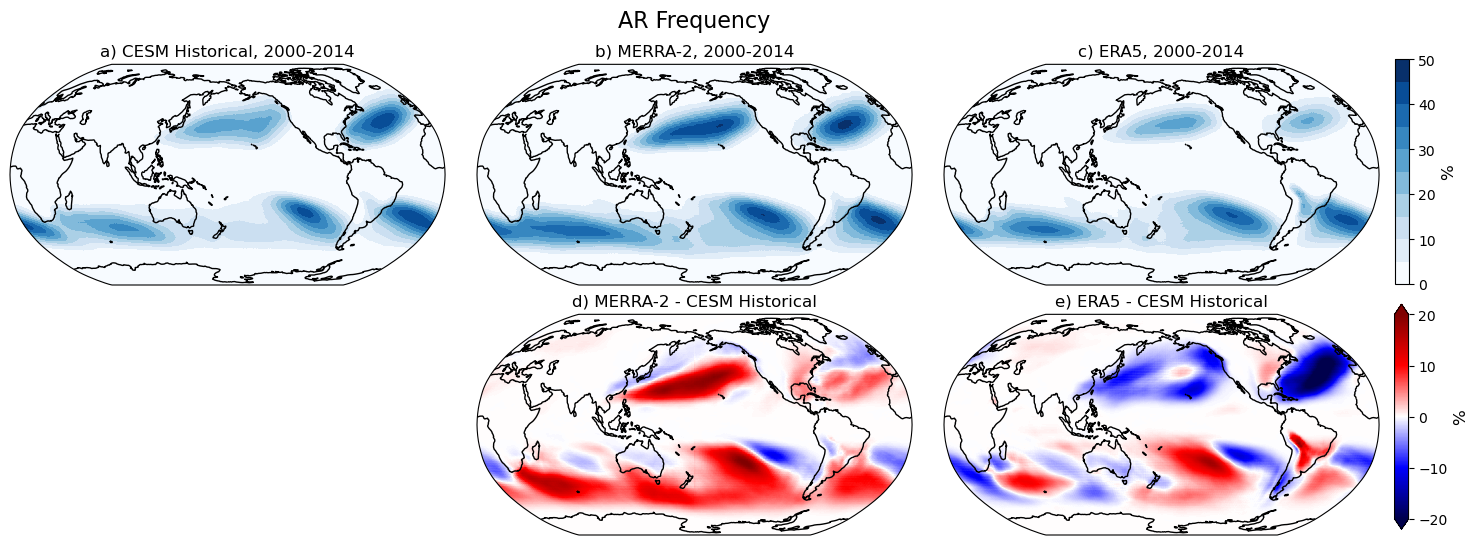

In [56]:
#fig, ax = plt.subplots(2, 3, figsize=(14,8), subplot_kw={'projection': ccrs.Robinson(central_longitude=180.0)}) # figsize is width, height
fig, ax = plt.subplot_mosaic([['upper left', 'upper middle', 'upper right'],
                               ['X', 'lower middle', 'lower right']], empty_sentinel='X',
                              figsize=(14,5), layout="constrained",
                              subplot_kw={'projection': ccrs.Robinson(central_longitude=180.0)})

# colormap/scale for absolute plots
cmap=plt.cm.get_cmap('Blues', 10)
vmax=50

# CESM Hist
lat = npercentARs.lat
lon = npercentARs.lon
pc = ax['upper left'].pcolormesh(lon, lat, npercentARs, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
ax['upper left'].coastlines()
ax['upper left'].set_title('a) CESM Historical, 2000-2014', fontsize=12)

# MERRA
lat = npercentARs_merra.lat
lon = npercentARs_merra.lon
pc = ax['upper middle'].pcolormesh(lon, lat, npercentARs_merra, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
ax['upper middle'].coastlines()
ax['upper middle'].set_title('b) MERRA-2, 2000-2014', fontsize=12)

# ERA
lat = npercentARs_era.lat
lon = npercentARs_era.lon
pc = ax['upper right'].pcolormesh(lon, lat, npercentARs_era, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
ax['upper right'].coastlines()
ax['upper right'].set_title('c) ERA5, 2000-2014', fontsize=12)

# add colorbar for absolute plots
cbar_ax = fig.add_axes([1.0, 0.51, 0.01, 0.45]) #(left, bottom, width, height)
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='vertical')
cbar.ax.set_ylabel('%', fontsize=12)

# colormap/scale for diff plots
cmap=plt.cm.get_cmap('seismic')
vmin=-20
vmax=20

# MERRA - Hist
lat = npercentARs_merra_diff.lat
lon = npercentARs_merra_diff.lon
pc = ax['lower middle'].pcolormesh(lon, lat, npercentARs_merra_diff, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
ax['lower middle'].coastlines()
ax['lower middle'].set_title('d) MERRA-2 - CESM Historical', fontsize=12)

# ERA - Hist
lat = npercentARs_era_diff.lat
lon = npercentARs_era_diff.lon
pc = ax['lower right'].pcolormesh(lon, lat, npercentARs_era_diff, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
ax['lower right'].coastlines()
ax['lower right'].set_title('e) ERA5 - CESM Historical', fontsize=12)

# add colorbar
cbar_ax = fig.add_axes([1.0, 0.02, 0.01, 0.45])
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='vertical', extend='both')
cbar.ax.set_ylabel('%', fontsize=12);

# add suptitle
fig.suptitle('AR Frequency', fontsize=16, y=1.06);

#plt.subplots_adjust(wspace=0.1, hspace=0) # can't use with subplot_mosaic

#plt.savefig('../figures/toSCP/npercentARs_CESM_hist_merra_era_diffs.png', dpi=300, bbox_inches='tight')

## Panel plot with 2 reanalysis datasets and differences

### Remap ERA to MERRA T2 grid to calculate diffs
Use `periodic=True` in regridder to avoid missing data on prime meridian. (There is still a line though?)

In [45]:
%%time
regridder_merra_t2 = xe.Regridder(npercentARs_era, npercentARs_merra_t2, "bilinear", periodic=True)
regridder_merra_t2

CPU times: user 15.7 s, sys: 386 ms, total: 16.1 s
Wall time: 17.2 s


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_721x1440_361x576_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (721, 1440) 
Output grid shape:          (361, 576) 
Periodic in longitude?      True

In [49]:
%%time
npercentARs_era_merrat2grid = regridder_merra_t2(npercentARs_era, keep_attrs=True)
npercentARs_era_merrat2grid

CPU times: user 20 ms, sys: 7 µs, total: 20 ms
Wall time: 22.3 ms


<xarray.DataArray 'ar_binary_tag' (lat: 361, lon: 576)>
dask.array<_regrid, shape=(361, 576), dtype=float64, chunksize=(361, 576), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float32 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
Attributes:
    regrid_method:  bilinear

In [50]:
npercentARs_era_merrat2grid = npercentARs_era_merrat2grid.persist()

In [48]:
npercentARs_merra_t2grid.max().values

array(42.63475695)

In [51]:
# era minus merra tier 2
npercentARs_t2_diff = npercentARs_era_merrat2grid - npercentARs_merra_t2

In [53]:
print(npercentARs_t2_diff.max().values, npercentARs_t2_diff.min().values)

23.44634057309728 -28.533331973661724


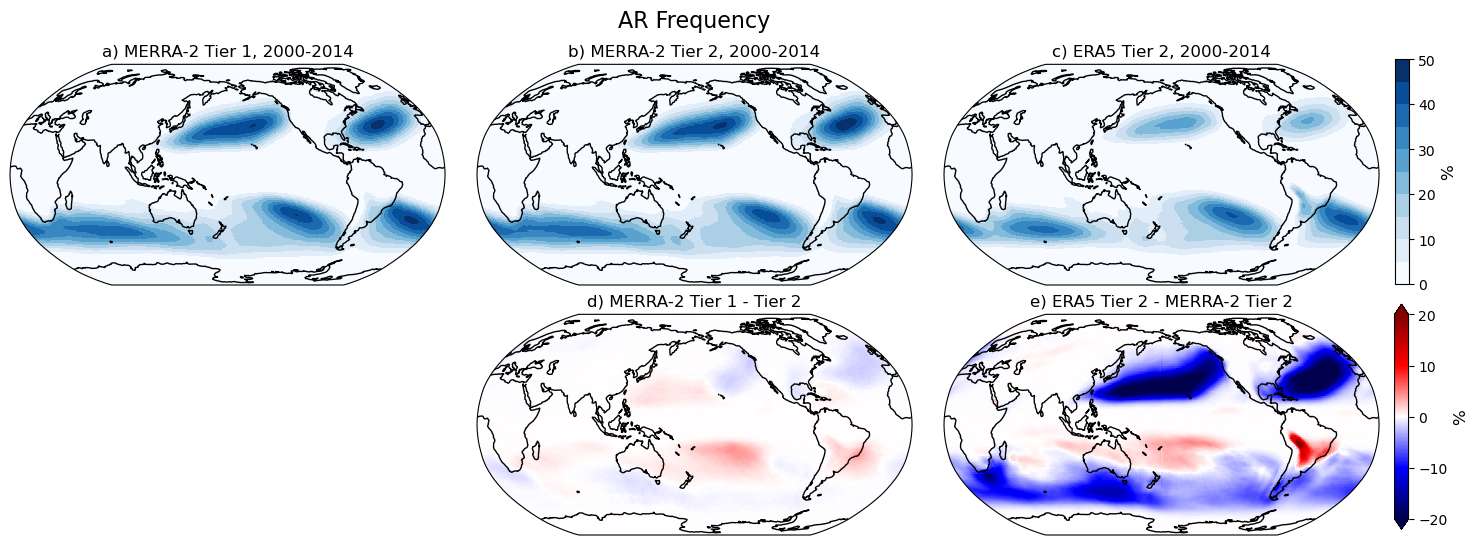

In [55]:
fig, ax = plt.subplot_mosaic([['upper left', 'upper middle', 'upper right'],
                               ['X', 'lower middle', 'lower right']], empty_sentinel='X',
                              figsize=(14,5), layout="constrained",
                              subplot_kw={'projection': ccrs.Robinson(central_longitude=180.0)})

# colormap/scale for absolute plots
cmap=plt.cm.get_cmap('Blues', 10)
vmax=50

# MERRA Tier 1
lat = npercentARs_merra.lat
lon = npercentARs_merra.lon
pc = ax['upper left'].pcolormesh(lon, lat, npercentARs_merra, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
ax['upper left'].coastlines()
ax['upper left'].set_title('a) MERRA-2 Tier 1, 2000-2014', fontsize=12)

# MERRA Tier 2
lat = npercentARs_merra_t2.lat
lon = npercentARs_merra_t2.lon
pc = ax['upper middle'].pcolormesh(lon, lat, npercentARs_merra_t2, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
ax['upper middle'].coastlines()
ax['upper middle'].set_title('b) MERRA-2 Tier 2, 2000-2014', fontsize=12)

# ERA
lat = npercentARs_era.lat
lon = npercentARs_era.lon
pc = ax['upper right'].pcolormesh(lon, lat, npercentARs_era, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
ax['upper right'].coastlines()
ax['upper right'].set_title('c) ERA5 Tier 2, 2000-2014', fontsize=12)

# add colorbar for absolute plots
cbar_ax = fig.add_axes([1.0, 0.51, 0.01, 0.45]) #(left, bottom, width, height)
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='vertical')
cbar.ax.set_ylabel('%', fontsize=12)

# colormap/scale for diff plots
cmap=plt.cm.get_cmap('seismic')
vmin=-20
vmax=20

# MERRA Tier 1 - MERRA Tier 2
lat = npercentARs_merra_tierdiff.lat
lon = npercentARs_merra_tierdiff.lon
pc = ax['lower middle'].pcolormesh(lon, lat, npercentARs_merra_tierdiff, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
ax['lower middle'].coastlines()
ax['lower middle'].set_title('d) MERRA-2 Tier 1 - Tier 2', fontsize=12)

# ERA - MERRA Tier 2
lat = npercentARs_t2_diff.lat
lon = npercentARs_t2_diff.lon
pc = ax['lower right'].pcolormesh(lon, lat, npercentARs_t2_diff, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
ax['lower right'].coastlines()
ax['lower right'].set_title('e) ERA5 Tier 2 - MERRA-2 Tier 2', fontsize=12)

# add colorbar
cbar_ax = fig.add_axes([1.0, 0.02, 0.01, 0.45])
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='vertical', extend='both')
cbar.ax.set_ylabel('%', fontsize=12);

# add suptitle
fig.suptitle('AR Frequency', fontsize=16, y=1.06);

#plt.subplots_adjust(wspace=0.1, hspace=0) # can't use with subplot_mosaic

#plt.savefig('../figures/toSCP/npercentARs_merra_era_diffs.png', dpi=300, bbox_inches='tight')

## Function to read and save global maps
To compare training with different input variables

In [ ]:
#folder_name = ["/masks_unwgt/", "/masks_TMQ_V850/". "/masks_TMQ/"]

In [50]:
def global_map(folder_name):
    cesm_cnet_filepath = "/glade/campaign/cgd/ccr/kdagon/cgnet/" # retrained NCAR model, after data processing workflow was finalized
    
    hist_yrs = [str(i) for i in range(2000,2006)]
    hist_folders = ["B20TRC5CN/"+y+folder_name for y in hist_yrs]
    rcp26_yrs = [str(i) for i in range(2006,2016)]
    rcp26_folders = ["BRCP26C5CN/"+y+folder_name for y in rcp26_yrs]
    
    cnet_file = 'class_masks.nc'
    paths = [cesm_cnet_filepath+hist_folders[i]+cnet_file for i,f in enumerate(hist_folders)] + [cesm_cnet_filepath+rcp26_folders[i]+cnet_file for i,f in enumerate(rcp26_folders)]
    cnet = xr.open_mfdataset(paths, concat_dim='time', combine='nested', chunks={'time':50}, parallel=True)
    cnet_mask = cnet.masks

    npercentARs = 100*((cnet_mask.clip(min=1)-1).sum(dim='time'))/len(cnet_mask.time)
    npercentARs = npercentARs.persist()
    max_ARs = npercentARs.max().values

    npercentTCs = 100*(cnet_mask.where(cnet_mask==1).sum(dim='time'))/len(cnet_mask.time)
    npercentTCs = npercentTCs.persist()
    max_TCs = npercentTCs.max().values
    
    return npercentARs, max_ARs, npercentTCs, max_TCs

In [51]:
# 4 variables
npercentARs, max_ARs, npercentTCs, max_TCs = global_map("/masks_unwgt/")

In [53]:
print(max_ARs, max_TCs)

44.61044520547945 17.429366438356166


In [54]:
# TMQ and V850
npercentARs_v2, max_ARs_v2, npercentTCs_v2, max_TCs_v2 = global_map("/masks_TMQ_V850/")
print(max_ARs_v2, max_TCs_v2)

50.54366438356164 15.286815068493151


In [55]:
# TMQ
npercentARs_v3, max_ARs_v3, npercentTCs_v3, max_TCs_v3 = global_map("/masks_TMQ/")
print(max_ARs_v3, max_TCs_v3)

45.32320205479452 0.012842465753424657


### Panel plot

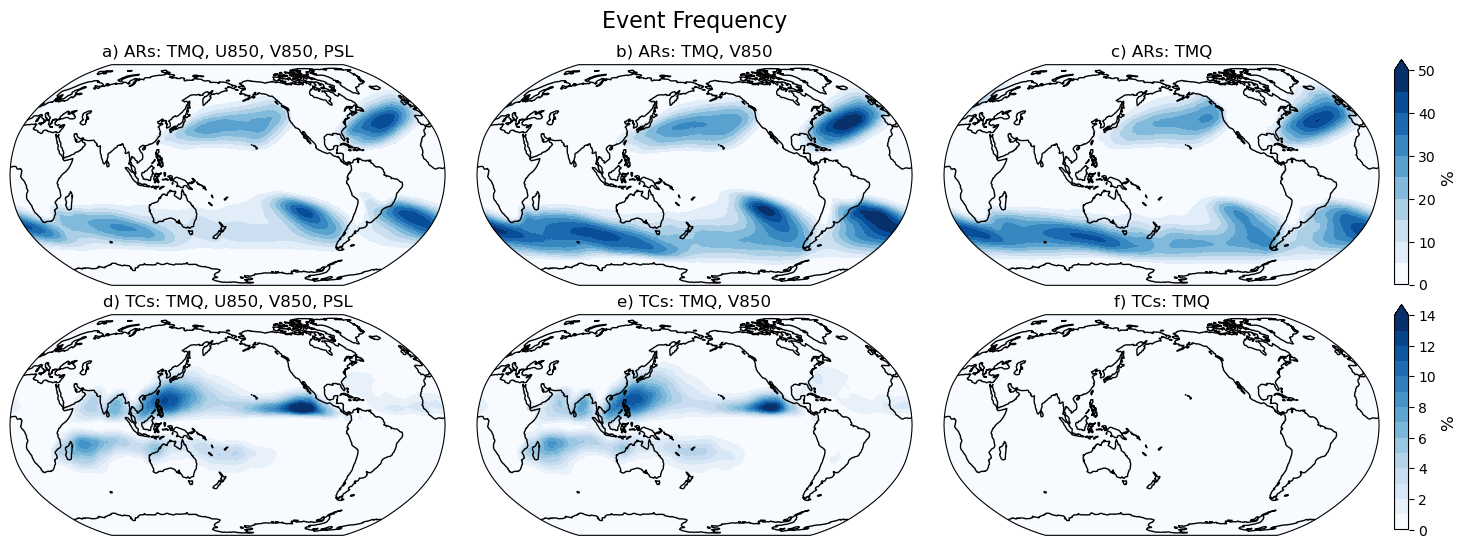

In [59]:
fig, ax = plt.subplot_mosaic([['upper left', 'upper middle', 'upper right'],
                               ['lower left', 'lower middle', 'lower right']],
                              figsize=(14,5), layout="constrained",
                              subplot_kw={'projection': ccrs.Robinson(central_longitude=180.0)})

# AR maps

# colormap/scale for AR plots
cmap=plt.cm.get_cmap('Blues', 10)
vmax=50

# 4 variables
lat = npercentARs.lat
lon = npercentARs.lon
pc1 = ax['upper left'].pcolormesh(lon, lat, npercentARs, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
ax['upper left'].coastlines()
ax['upper left'].set_title('a) ARs: TMQ, U850, V850, PSL')
#ax['upper left'].set_ylabel('ARs') # doesn't work (no y axis?)

# TMQ, V850
lat = npercentARs_v2.lat
lon = npercentARs_v2.lon
pc2 = ax['upper middle'].pcolormesh(lon, lat, npercentARs_v2, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
ax['upper middle'].coastlines()
ax['upper middle'].set_title('b) ARs: TMQ, V850')
#ax['upper middle'].set_ylabel('ARs')

# TMQ
lat = npercentARs_v3.lat
lon = npercentARs_v3.lon
pc3 = ax['upper right'].pcolormesh(lon, lat, npercentARs_v3, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
ax['upper right'].coastlines()
ax['upper right'].set_title('c) ARs: TMQ')
#ax['upper right'].set_ylabel('ARs')

# colorbar for AR maps
cbar_ax = fig.add_axes([1.0, 0.51, 0.01, 0.45]) #(left, bottom, width, height)
cbar = plt.colorbar(pc1, cax=cbar_ax, orientation='vertical', extend='max')
cbar.ax.set_ylabel('%', fontsize=12)

# TC maps

# colormap/scale for TC plots
cmap=plt.cm.get_cmap('Blues', 14)
vmax=14

# 4 variables
lat = npercentTCs.lat
lon = npercentTCs.lon
pc4 = ax['lower left'].pcolormesh(lon, lat, npercentTCs, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
ax['lower left'].coastlines()
ax['lower left'].set_title('d) TCs: TMQ, U850, V850, PSL')
#ax['lower left'].set_ylabel('TCs')

# TMQ, V850
lat = npercentTCs_v2.lat
lon = npercentTCs_v2.lon
pc5 = ax['lower middle'].pcolormesh(lon, lat, npercentTCs_v2, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
ax['lower middle'].coastlines()
ax['lower middle'].set_title('e) TCs: TMQ, V850')
#ax['lower middle'].set_ylabel('TCs')

# TMQ
lat = npercentTCs_v3.lat
lon = npercentTCs_v3.lon
pc6 = ax['lower right'].pcolormesh(lon, lat, npercentTCs_v3, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
ax['lower right'].coastlines()
ax['lower right'].set_title('f) TCs: TMQ')
#ax['lower right'].set_ylabel('TCs')

# colorbar for TC maps
cbar2_ax = fig.add_axes([1.0, 0.02, 0.01, 0.45]) #(left, bottom, width, height)
cbar2 = plt.colorbar(pc4, cax=cbar2_ax, orientation='vertical', extend='max')
cbar2.ax.set_ylabel('%', fontsize=12)

# add suptitle
fig.suptitle('Event Frequency', fontsize=16, y=1.06)

#plt.savefig('../figures/toSCP/npercentARs_TCs_comparevars.png', dpi=300, bbox_inches='tight')

### Close cluster/client as needed

In [56]:
client.close()
cluster.close()